In [3]:
using Distributions
using Random
using Plots
using PyPlot
using StatsBase
using StatsPlots
using Serialization
using LinearAlgebra

# Problem-Suite

Problem-Suite is a large structured notebook containing all of the functions created so far for this project.

Sections:

-[Miscellaneous Functions](#Miscellaneous-Functions)

-[Pre-requisite functions for uniformised AVI](#Pre-requisite-functions-for-uniformised-AVI)

-[Uniformised AVI functions](#Uniformised-AVI-functions)

-[Pre-requisite functions for SMARVI](#Pre-requisite-functions-for-SMARVI)

-[SMARVI Functions](#SMARVI-Functions)

-[Pre-requisite Functions for Exact DP on Homogeneous Problems](#Pre-requisite-Functions-for-Exact-DP-on-Homogeneous-Problems)

-[Exact DP on Homogeneous Problems (RVIA and PE/PI)](#Exact-DP-for-Homogeneous-problem)

-[Pre-requisite Functions for Exact DP on Inhomogeneous Problems](#Pre-requisite-Functions-for-Exact-DP-on-Inhomogeneous-Problems)

-[Exact DP on Inhomogeneous Problems (RVIA and PE/PI)](#Exact-DP-for-Inhomogeneous-Problem-(using-exact-h-or-VFA))

-[Evaluation via simulation](#Evaluation-via-simulation)

-[APE on Fully Active Policy](#APE-on-Fully-Active-Policy)

-[SMARPE](#SMARPE)

-[Tabular SMARVI and gEval](#tabular-smarvi-and-geval)

-[SMART Functions](#SMART-Functions)

-[SMARVI - New VFA](#SMARVI---New-VFA)

-[SMARPI New VFA Functions](#SMARPI-New-VFA-Functions)

-[Tests](#Tests)

# Miscellaneous Functions

-Functions for enumerating state and action spaces

-Functions for calculating flows given a state or state-action pair

-Function for evaluating a VFA at a given state

In [4]:
#produce an array of array representations of all possible states
function enumerateStates(N::Int64)
    if N==1
        return [[1],[2],[3]]
    end
    
    output = []
    lower = enumerateStates(N-1)
    for s in lower
        new1 = append!([1],s)
        new2 = append!([2],s)
        new3 = append!([3],s)
        append!(output,[new1])
        append!(output,[new2])
        append!(output,[new3])
    end
    
    return output
end

#produce an array of array representations of all possible actions
function enumerateActions(N::Int64)
    if N==1
        return [[0],[1]]
    end
    
    output = []
    lower = enumerateActions(N-1)
    for a in lower
        new1 = append!([0],a)
        new2 = append!([1],a)
        append!(output,[new1])
        append!(output,[new2])
    end
    
    return output
end    

#produce array of array representations of all restricted, or single-repair, actions
function enumerateRestrictedActions(N::Int64)
    if N==1
        return [[0],[1]]
    end
    
    output = [zeros(Int64,N)]
    for i in 1:N
        temp = zeros(N)
        temp[i] = 1
        append!(output,[temp])
    end
    
    return output
end

#convert all array elements to string, then concatanate all elements (DEPRECATED AS DICTS CAN TAKE ARRAYS AS KEYS)
function arrayToString(x)
    return join(string.(x))
end

arrayToString (generic function with 1 method)

In [5]:
#function for calculating the flows given a state
function calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    #update flows
    flows = zeros(N)
    healthy = sum(i == 1 for i in s)
    
    #if no links are healthy, return 
    if healthy == 0
        return flows, c1
    end
    
    #otherwise, find best route, and return
    bestCost = maximum(c0) + 1
    usedLink = 0
    for k in 1:N
        if s[k] == 1 && c0[k] < bestCost
            bestCost = c0[k]
            usedLink = k
        end
    end
    
    flows[usedLink] = beta
    
    return flows, bestCost
end

#function for calculating the flows given a state-action pair
function calculateFlows(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    sPrime = s - a
    return calculateFlows(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
end

calculateFlows (generic function with 2 methods)

In [6]:
#evaluate a VFA at a given state
function v(s::Vector{Int64}, params::Vector{Float64}, features::Vector{Function})
    numFeatures = length(features)
    return params[1] + sum(params[i+1]*features[i](s) for i in 1:numFeatures)
end

v (generic function with 1 method)

In [7]:
#version of v that takes flows for the features
function v(s::Vector{Int64}, flows::Vector{Float64}, params::Vector{Float64}, features::Vector{Function})
    N = length(params)
    return params[1] + sum(params[i]*features[i-1](s, flows) for i in 2:N)
end

v (generic function with 2 methods)

In [8]:
#Note here that tau is a vector of independend repair rates
function calculatePi_SSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, lambda)
    mu = fill(0.0, N)
    nu = tau + alpha_r + lambda
    pi = fill(0.0, N, 3) #index by pi[edge, state]
    alpha_u = beta*alpha_d + alpha_r
    mu[1] = alpha_u[1]
    pi[1,1] = lambda[1]*tau[1]/(mu[1]*nu[1]+lambda[1]*tau[1])
    pi[1,2] = (lambda[1]/nu[1])*(1 - pi[1,1])
    pi[1,3] = 1 - pi[1,1] - pi[1,2]

    useprob = 1
    for i in 2:N
        useprob = useprob*(1 - pi[i-1,1])
        mu[i] = useprob*alpha_u[i] + (1 - useprob)alpha_r[i]
        normConst = mu[i]*nu[i] + lambda[i]*tau[i]
        pi[i,1] = tau[i]*lambda[i]/normConst
        pi[i,2] = (lambda[i]/nu[i])*(1 - pi[i,1])
        pi[i,3] = 1 - pi[i,1] - pi[i,2]
    end

    return pi
end

calculatePi_SSP (generic function with 1 method)

In [9]:
function calculateG_SSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, lambda)
    pi = calculatePi_SSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, lambda)
    prodNonHealthy = fill(0.0, N)
    prodNonHealthy[1] = 1 - pi[1,1]
    for i in 2:N
        prodNonHealthy[i] = prodNonHealthy[i-1]*(1 - pi[i,1])
    end

    return sum(r[i]*pi[i,2] for i in 1:N) + beta*c0[1]pi[1,1] + sum(beta*c0[i]*pi[i,1]*prodNonHealthy[i-1] for i in 2:N)+ beta*c1*prodNonHealthy[N], pi
end

calculateG_SSP (generic function with 1 method)

In [10]:
function calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, dsPolicy)
    if dsPolicy == fill(0,N)
        return beta*c1
    end
    S = []
    K = 0

    #calculate S the set of maintained links and K the number of maintained links
    prodNonHealthy = [1.0]
    prodNonHealthyCurrent = 1
    for i in 1:N
        if dsPolicy[i] == 1
            push!(S, i)
            K+=1
        end
    end

    #calculate p_AD(j in S, j<i) for all i in S, and p_AD(i in S)
    for i in S
        prodNonHealthyCurrent = prodNonHealthyCurrent*alpha_r[i]/(alpha_r[i] + tau[i])
        push!(prodNonHealthy, prodNonHealthyCurrent)
    end

    #calculate and return g
    return sum(r[S[i]]*alpha_r[S[i]]/(alpha_r[S[i]] + tau[S[i]]) + beta*c0[S[i]]*tau[S[i]]*prodNonHealthy[i]/(alpha_r[S[i]] + tau[S[i]]) for i in 1:K) + beta*c1*prodNonHealthy[K+1]
end

calculateG_DSP (generic function with 1 method)

In [11]:
function calculateG_SSP_Homog(N,alpha_d, alpha_r, beta, tau, c0, c1, r, lambdaActive, K)
    alpha_d = [alpha_d for i in 1:N]
    alpha_r = [alpha_r for i in 1:N]
    c0 = fill(c0, N)
    r = fill(r, N)
    lambda = fill(0.0, N)
    for i in 1:K
        lambda[i] = lambdaActive
    end

    return calculateG_SSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, lambda)
end

calculateG_SSP_Homog (generic function with 1 method)

In [12]:
#Computes the Fully Active action for a given state s
function faAction(s)
    N = length(s)
    a = zeros(Int64,N)
    for i in 1:N
        if s[i] == 3
            a[i] = 1
        end
    end
    return a
end

faAction (generic function with 1 method)

# Pre-requisite functions for uniformised AVI

This section contains functions used within the AVI algorithms

Given a state-action pair, return the next random pre-decision state, the instant cost, and the updated flows

In [13]:
function updateStateAndFlowsUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    #observe exogenous information
    w = rand(Uniform(0, 1))
    
    #interpret exog info: is it a demand deg, rare deg, or completed repair 
    found = false
    runningTotal = 0
    
    #demand degs
    for k in 1:N
        if runningTotal <= w <= runningTotal + flows[k]*alpha_d[k]*del
            found = true
            sPrime[k] = 3
            #println("Demand Deg at "*string.(k))
            break
        end
        runningTotal = runningTotal + flows[k]*alpha_d[k]*del
    end
    
    #rare degs
    if found == false
        for k in 1:N
            if runningTotal <= w <= runningTotal + (s[k]!=3)*alpha_r[k]*del
                found = true
                sPrime[k] = 3
                #println("Rare Deg at "*string.(k))
                break
            end
            runningTotal = runningTotal + alpha_r[k]*del
        end
    end
    
    #repairs
    if found == false
        for k in 1:N
            if runningTotal <= w <= runningTotal + (s[k]==2)*tau[k]*del
                found = true
                sPrime[k] = 1
                break
            end
            runningTotal = runningTotal + (s[k]==2)*tau[k]*del
        end
    end
    
    if found == false
        #println("NO EVENT")
    end
    
    #update flows
    flowUpdate = calculateFlows(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    newFlows = flowUpdate[1]
    bestCost = flowUpdate[2]
    healthy = sum(i == 1 for i in sPrime)
    
    return sPrime, (beta*bestCost + sum(r[k]*(sPrime[k]==2) for k in 1:N))*del, newFlows
end

updateStateAndFlowsUnif (generic function with 1 method)

Given a state action pair, return the instant cost over the delta timestep.

In [14]:
#instant cost over the timestep
function instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    #immediate change
    sPrime = s - a
    healthy = sum(sPrime[i] == 1 for i in 1:N)
    repair = sum(sPrime[i] == 2 for i in 1:N)
    damaged = sum(sPrime[i] == 3 for i in 1:N)
    
    #update flows
    flowUpdate = calculateFlows(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    newFlows = flowUpdate[1]
    bestCost = flowUpdate[2]
    
    return (beta*bestCost + sum(r[k]*(sPrime[k]==2) for k in 1:N))*del
end

instantCostUnif (generic function with 1 method)

# Pre-requisite functions for SMARVI

Helper functions for the SMARVI algorithms

Given a state-action pair and pre-calculated flows, return the expected sojourn time for the state-action pair.

In [15]:
#Calculate the expected sojourn time of a state-action pair
function sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    s = s - a
    if s == fill(3,N)
        return 1/(beta*sum(alpha_d) + sum(alpha_r) + sum(tau))
    end
    
    
    totalRate = sum(flows[i]*alpha_d[i] + alpha_r[i]*(s[i]!=3) + tau[i]*(s[i]==2) for i in 1:N)
    
    return 1/totalRate
end

sojournTime (generic function with 1 method)

Given a state-action pair and flows, calculate the expected cost accumulated until a transition occurs, or calculate the simulated cost accumulated over a simulated time del.

In [16]:
#calculate the expected cost accumulated until a transition 
function instantCostCont(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows; del = 0)
    if del == 0
        del = sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    end
    
    return instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
end

instantCostCont (generic function with 1 method)

Given a state-action pair, return the next random pre-decision state, the cost accumulated over the sojourn time, and the updated flows

In [17]:
function updateStateAndFlowsCont(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
    #immediate change
    sPrime = s - a
    sOld = copy(sPrime)
    flowsOld = copy(flows)
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    #deal with all-damaged edge case
    if sPrime == fill(3, N)
        del = 1/(sum(beta*alpha_d) + sum(alpha_r) + tau(N))
        return sPrime, beta*c1*del, flows, del
    end

    #create list of events (degradations for all non-damaged links and repair events for all repairing links) and list of rates
    events = [i for i in 1:N if sPrime[i]!=3]
    eventsRep = [N + i for i in 1:N if sPrime[i] == 2]
    append!(events, eventsRep)

    rates = [flows[i]*alpha_d[i] + alpha_r[i] for i in 1:N if sPrime[i]!=3]
    ratesRep = [tau[i] for i in 1:N if sPrime[i] == 2]
    append!(rates, ratesRep)

    #sample event
    del = 1/sum(rates)
    event = wsample(events, rates)

    #if event >= N+1, it's a repair, otherwise it's a degradation
    if event >= N + 1 
        sPrime[event - N] = 1
    else
        sPrime[event] = 3
    end
    
    #update flows
    flowUpdate = calculateFlows(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    newFlows = flowUpdate[1]
    bestCost = flowUpdate[2]
    
    return sPrime, (beta*c1*(healthy == 0) + sum(flowsOld[k]*c0[k] + r[k]*(sOld[k]==2) for k in 1:N))*del, newFlows, del
end

updateStateAndFlowsCont (generic function with 1 method)

Generate random action for e-greedy algorithms

In [18]:
#Calculate random action for e-greedy algorithms
function randomAction(s,N)
    #deal with all-damaged case
    if s == fill(3,N)
        return randomActionAllDamaged(N)
    end

    damaged = [0]
    for i in 1:N
        if s[i] == 3
            append!(damaged, [i])
        end
    end
            
    choice = sample(damaged)
    optA = zeros(Int64, N)
    if choice == 0
        return optA
    else
        optA[choice] = 1
        return optA
    end
end

#calculate random action for [3,3...,3] state
function randomActionAllDamaged(N)
    choice = sample(1:N)
    a = zeros(Int64, N)
    a[choice] = 1
    return a
end

randomActionAllDamaged (generic function with 1 method)

# Pre-requisite Functions for Exact DP on Homogeneous Problems 

Helper functions for Homogeneous Exact DP

Calculates instant cost for homogeneous problem

In [19]:
#instant cost function strictly for homogeneous problem
function instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    #immediate change
    i1Prime = i1 - a
    i2Prime = i2 + a
    
    #if no links are healthy, return 
    if N - i1 - i2 == 0
        return (beta*c1 + r*i2Prime)*del
    end
    
    
    return (beta*c0 + r*i2Prime)*del
end

instantCostHomog (generic function with 1 method)

Given state (i_1, i_2) and action a, calculates the expected next value function after one timestep

In [20]:
#calculates E(h(s')) from s,a strictly for a homogeneous problem
function expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    #immediate change
    i1Prime = i1 - a
    i2Prime = i2 + a
    thisH = h[i1+1,i2+1]
    
    #if all are damaged
    if i1Prime == N
        return thisH
    end
    
    #if none are healthy
    if N - i1 - i2 == 0
        return thisH + tau*i2Prime*del*(h[i1Prime+1,i2Prime-1+1] - thisH) + i2Prime*del*alpha_r*(h[i1Prime+1+1, i2Prime-1+1] - thisH)
    end
    
    #if none are repairing
    if i2Prime == 0
        return thisH + (beta*alpha_d + (N - i1 - i2)*alpha_r)*del*(h[i1Prime+1+1,i2Prime+1] - thisH)
    end
    
    return thisH + (beta*alpha_d + (N - i1 - i2)*alpha_r)*del*(h[i1Prime+1+1,i2Prime+1] - thisH) + i2Prime*alpha_r*del*(h[i1Prime+1+1,i2Prime-1+1] - thisH) + tau*i2Prime*del*(h[i1Prime+1,i2Prime-1+1] - thisH)
end

expectedNextValueHomog (generic function with 1 method)

Given state (i_1,i_2) and value function h, calculates and returns the best action for the state using full expectations.

In [21]:
#calculates the exact PI action strictly for a homogeneous problem
function piActionHomog(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = false)
    if i1 == 0
        return 0
    end
    
    if i1 == N && forceActive
        optA = 1
        optH = instantCostHomog(i1,i2,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        for a in 2:i1
            testH = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            if testH <= optH
                optA = a
                optH = testH
            end
        end
        return optA
    end
    
    optA = 0
    optH = instantCostHomog(i1,i2,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    for a in 1:i1
        testH = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        if testH <= optH
            optA = a
            optH = testH
        end
    end
    
    return optA
end

piActionHomog (generic function with 1 method)

Similar to above, but uses the approximation Q(s,a) = h(s+a) for a!=0

In [22]:
#calculates the approx PI action based on instantaneous approximation, strictly for a homogeneous problem
function piActionHomogApprox(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g; forceActive = false)
    #deal with "nothing damaged" edge case
    if i1 == 0
        return 0
    end
    
    #deal with "everything damaged" edge case
    if i1 == N && forceActive
        optA = 1
        optH = h[i1-optA+1,i2+optA+1]
        for a in 2:i1
            testH = h[i1-a+1,i2+a+1]
            if testH <= optH
                optA = a
                optH = testH
            end
        end
        return optA
    end
    
    optA = 0
    optH = instantCostHomog(i1,i2,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) - g*del
    for a in 1:i1
        testH = h[i1-a+1,i2+a+1]
        if testH <= optH
            optA = a
            optH = testH
        end
    end
    
    return optA
end

piActionHomogApprox (generic function with 1 method)

Given h, constructs optimal policy using exact PI method

In [23]:
#calculates the exact PI policy strictly for a homogeneous problem
function piPolicyHomog(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = false)
    policy = zeros(Int64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            policy[i1+1,i2+1] = piActionHomog(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = forceActive)
        end
    end
    
    return policy
end

piPolicyHomog (generic function with 1 method)

Given h, constructs optimal policy using Q(s,a) = h(s,a) for a!=0 approximation

In [24]:
#calculates the approx PI policy based on instantaneous approximation, strictly for a homogeneous problem
function piPolicyHomogApprox(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g; forceActive = false)
    policy = zeros(Int64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            policy[i1+1,i2+1] = piActionHomogApprox(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g; forceActive = forceActive)
        end
    end
    
    return policy
end

piPolicyHomogApprox (generic function with 1 method)

Constructs a h table from a VFA

In [25]:
function hFromVFAHomog(N, params, features)
    #construct hIn table
    hIn = zeros(Float64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            s = fill(1,N)
            if i1 > 0
                for i in 1:i1
                    s[i] = 3
                end
            end
            
            if i2 > 0
                for i in (i1+1):(i1+i2)
                    s[i] = 2
                end
            end
            
            hIn[i1+1,i2+1] = v(s, params, features)
        end
    end
    
    return hIn
end

hFromVFAHomog (generic function with 1 method)

# Exact DP for Homogeneous problem

Actual DP algorithms 

Given a h table, performs PE on PI policy derived from h, and returns g, h, n (number of iterations), and the PI policy

In [26]:
#Evaluates a PI policy based on a given exact h function, strictly for a homogeneous problem 
function rpiHomog(N::Int64, hIn, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64; nMax = 0, delScale = 1, forceActive = false)
    #calculate stepsize and initialise h,w,and policy vectors
    del = 1/(delScale*(beta*alpha_d + N*alpha_r + N*tau))
    h = zeros(Float64, N+1, N+1)
    w = zeros(Float64, N+1, N+1)
    policy = piPolicyHomog(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = forceActive)
    n = 0
    #repeat until epsilion-convergence or n = nMax
    while true
        n = n + 1
        #calculate new w values
        for i1 in 0:N
            for i2 in 0:(N - i1)
                a = policy[i1+1,i2+1]
                w[i1+1,i2+1] = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            end
        end
        
        
        #calculate new relative values
        hNew = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:(N - i1)
                hNew[i1+1,i2+1] = w[i1+1,i2+1] - w[1,1]
            end
        end
        
        #check for convergence
        deltas = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:N-i1
                deltas[i1+1,i2+1] = hNew[i1+1,i2+1] - h[i1+1,i2+1]
            end
        end
        
        h = hNew
        if maximum(deltas) < epsilon || n == nMax
            break
        end
    end
    
    v = beta*c0*del + (beta*alpha_d + (N)*alpha_r)*del*h[1+1,0+1] + (1 - (beta*alpha_d + (N)*alpha_r)*del)*h[0+1,0+1]
    
    return v/del, h, n, policy
end

rpiHomog (generic function with 1 method)

Performs PE on the fully active policy

In [27]:
#Evaluates the fully active policy, strictly for a homogeneous problem 
function rpeFAHomog(N::Int64, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64; nMax = 0, delScale = 1, forceActive = false)
    #calculate stepsize and initialise h,w,and policy vectors
    del = 1/(delScale*(beta*alpha_d + N*alpha_r + N*tau))
    h = zeros(Float64, N+1, N+1)
    w = zeros(Float64, N+1, N+1)
    n = 0
    #repeat until epsilion-convergence or n = nMax
    while true
        n = n + 1
        #calculate new w values
        for i1 in 0:N
            for i2 in 0:(N - i1)
                a = i1
                w[i1+1,i2+1] = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            end
        end
        
        
        #calculate new relative values
        hNew = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:(N - i1)
                hNew[i1+1,i2+1] = w[i1+1,i2+1] - w[1,1]
            end
        end
        
        #check for convergence
        deltas = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:N-i1
                deltas[i1+1,i2+1] = hNew[i1+1,i2+1] - h[i1+1,i2+1]
            end
        end
        
        h = hNew
        if maximum(deltas) < epsilon || n == nMax
            break
        end
    end
    
    v = beta*c0*del + (beta*alpha_d + (N)*alpha_r)*del*h[1+1,0+1] + (1 - (beta*alpha_d + (N)*alpha_r)*del)*h[0+1,0+1]
    
    return v/del, h, n
end

rpeFAHomog (generic function with 1 method)

Similar to rpiHomog, but uses Q(s,a) = h(s,a) approximation for PI step.

In [28]:
#Evaluates an approximate PI policy based on a given exact h function and instananeous actions, strictly for a homogeneous problem 
function rpiHomogApprox(N::Int64, hIn, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64, g::Float64; nMax = 0, delScale = 1, forceActive = false)
    #calculate stepsize and initialise h,w,and policy vectors
    del = 1/(delScale*(beta*alpha_d + N*alpha_r + N*tau))
    h = zeros(Float64, N+1, N+1)
    w = zeros(Float64, N+1, N+1)
    policy = piPolicyHomogApprox(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g; forceActive = forceActive)
    n = 0
    #repeat until epsilion-convergence or n = nMax
    while true
        n = n + 1
        #calculate new w values
        for i1 in 0:N
            for i2 in 0:(N - i1)
                a = policy[i1+1,i2+1]
                w[i1+1,i2+1] = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            end
        end
        
        
        #calculate new relative values
        hNew = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:(N - i1)
                hNew[i1+1,i2+1] = w[i1+1,i2+1] - w[1,1]
            end
        end
        
        #check for convergence
        deltas = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:N-i1
                deltas[i1+1,i2+1] = hNew[i1+1,i2+1] - h[i1+1,i2+1]
            end
        end
        
        h = hNew
        if maximum(deltas) < epsilon || n == nMax
            break
        end
    end
    
    v = beta*c0*del + (beta*alpha_d + (N)*alpha_r)*del*h[1+1,0+1] + (1 - (beta*alpha_d + (N)*alpha_r)*del)*h[0+1,0+1]
    
    return v/del, h, n, policy
end

rpiHomogApprox (generic function with 1 method)

Performs RVIA

In [29]:
#Performs RVIA 
function rviHomog(N::Int64, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64; nMax = 0, delScale = 1, forceActive = false)
    #calculate stepsize and initialise h,w,and policy vectors
    del = 1/(delScale*(beta*alpha_d + N*alpha_r + N*tau))
    h = zeros(Float64, N+1, N+1)
    w = zeros(Float64, N+1, N+1)
    n = 0
    #repeat until epsilion-convergence or n = nMax
    while true
        n = n + 1
        #calculate new w values
        for i1 in 0:N
            for i2 in 0:(N - i1)
                a = piActionHomog(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = forceActive)
                w[i1+1,i2+1] = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            end
        end
        
        
        #calculate new relative values
        hNew = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:(N - i1)
                hNew[i1+1,i2+1] = w[i1+1,i2+1] - w[1,1]
            end
        end
        
        #check for convergence
        deltas = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:N-i1
                deltas[i1+1,i2+1] = hNew[i1+1,i2+1] - h[i1+1,i2+1]
            end
        end
        
        h = hNew
        if maximum(deltas) < epsilon || n == nMax
            break
        end
    end
    
    v = beta*c0*del + (beta*alpha_d + (N)*alpha_r)*del*h[1+1,0+1] + (1 - (beta*alpha_d + (N)*alpha_r)*del)*h[0+1,0+1]
    
    return v/del, h, n, piPolicyHomog(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = false)
end

rviHomog (generic function with 1 method)

# Pre-requisite Functions for Exact DP on Inhomogeneous Problems

Helper functions for inhomogeneous exact DP

Given a state-action pair and h, calculates the expected next value of the value function after one timestep.

In [30]:
#calculates E(h(s')) from s,a using exact h table
function expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    runningTotal = 0.0
    runningTotalProb = 0.0
    
    flows = zeros(Float64, N)
    if healthy > 0
        #otherwise, find best route, and return
        bestCost = maximum(c0) + 1
        usedLink = 0
        for k in 1:N
            if sPrime[k] == 1 && c0[k] < bestCost
                bestCost = c0[k]
                usedLink = k
            end 
        end
        
        flows[usedLink] = beta
    end
    
    
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        runningTotal += flows[k]*alpha_d[k]*del*h[sNext]
        runningTotalProb += flows[k]*alpha_d[k]*del
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            runningTotal += alpha_r[k]*del*h[sNext]
            runningTotalProb += alpha_r[k]*del
        end
    end
    
    #repairs
    for k in 1:N
        if sPrime[k] == 2
            sNext = copy(sPrime)
            sNext[k] = 1
            runningTotal += tau[k]*del*h[sNext]
            runningTotalProb += tau[k]*del
        end
    end
    
    return runningTotal + (1 - runningTotalProb)*h[sPrime]
end 

expectedNextValueExact (generic function with 1 method)

Given a state and a h table, calculates the PI action for s.

In [31]:
#calculates PI action using exact h table
function piActionExact(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    if s == fill(1, N)
        return zeros(Int64, N)
    end
    
    optA = zeros(Int64, N)
    optH = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,h)
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64,N)
            a[i] = 1
            testH = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,h)
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end
    return optA
end

piActionExact (generic function with 1 method)

Similar to above, but uses the approximation Q(s,a) = h(s+a)

In [32]:
#calculates PI action using exact h table, based off instananeous actions
function piActionExactInstant(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    if s == fill(1, N)
        return zeros(Int64, N)
    end
    
    optA = zeros(Int64, N)
    optH = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,h) - g*del
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64,N)
            a[i] = 1
            testH = h[s-a]
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end
    return optA
end

piActionExactInstant (generic function with 1 method)

Constructs PI policy using h table and no approximation

In [33]:
#calculates PI policy using exact h table
function piPolicyExact(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    policy = Dict()
    stateSpace = enumerateStates(N)
    for s in stateSpace
        policy[s] = piActionExact(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    end
    
    return policy
end

piPolicyExact (generic function with 1 method)

Constructs PI policy using h table and Q(s,a) = h(s+a) approximation

In [34]:
#calculates PI policy using exact h table, interpretting h with instant actions
function piPolicyExactInstant(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    policy = Dict()
    stateSpace = enumerateStates(N)
    for s in stateSpace
        policy[s] = piActionExactInstant(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    end
    
    return policy
end

piPolicyExactInstant (generic function with 1 method)

# Exact DP for Inhomogeneous Problem (using exact h or VFA)

DP algorithms for inhomogeneous problem

Note that throughout when we talk of a Q(s,a) = h(s+a) approximation, this only refers to action selection and not update rules, and excludes a=0

Given an explicit policy table, performs PE, returns g, h and n (# of iterations)

In [35]:
#Performs PE using exact policy table
function rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + sum(tau)))
    h = Dict()
    w = Dict()
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            a = policy[s]
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n
end

rpe (generic function with 1 method)

Given a h table, constructs PI policy and performs PE, returning g, h, n and the PI policy

In [36]:
#Performs one round of exact PI and PE using exact h table
function rpiExact(N, hIn, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + sum(tau)))
    policy = piPolicyExact(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    output = rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = printProgress, modCounter = modCounter)
    return output[1], output[2], output[3], policy
end

rpiExact (generic function with 1 method)

Similar to above, but uses Q(s,a) = h(s+a) approximation

In [37]:
#Performs one round of exact PI and PE using exact h table, using instant actions to interpet h
function rpiExactInstant(N, hIn, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon, g; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + sum(tau)))
    policy = piPolicyExactInstant(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    output = rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = printProgress, modCounter = modCounter)
    return output[1], output[2], output[3], policy
end

rpiExactInstant (generic function with 1 method)

Performs PE on the fully active policy

In [38]:
#Performs exact PE on the fully-active policy
function rpeFA(N, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    stateSpace = enumerateStates(N)
    policy = Dict()
    for s in stateSpace
        policy[s] = faAction(s)
    end
    
    return rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = printProgress, modCounter = modCounter)
end

rpeFA (generic function with 1 method)

Performs PE on fully passive policy

In [39]:
#Performs exact PE on the passive policy
function rpePassive(N, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    policy = Dict()
    for s in stateSpace
        policy[s] = zeros(Int64, N)
    end
    
    return rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = printProgress, modCounter = modCounter)
end

rpePassive (generic function with 1 method)

Performs RVIA

In [40]:
#Performs RVIA
function rvi(N, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = N, printProgress = true, modCounter = 1000)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + sum(tau)))
    h = Dict()
    w = Dict()
    policy = Dict()
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
        policy[s] = zeros(Int64,N)
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            a = piActionExact(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
            policy[s] = a
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n, policy
end

rvi (generic function with 1 method)

# Evaluation via simulation

Various evaluation functions for approximating g

Finds the g of the fully active policy

In [41]:
#Evaluates the FA policy
function gEvaluationFA(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax; s = fill(1,N), printProgress = false, modCounter = 100000, stateTrace = false)
    #initialise
    s0 = fill(1,N)
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    flows = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        
        #formulate FA action
        bestA = faAction(s)
        
        if stateTrace
            println(s)        
        end

        #update state, flows and g
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            g = (g*timePassed + c)/(timePassed + time)
            timePassed += time
        else
            s = s - bestA
        end
        
        append!(gs,[g])
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return g, gs, timePassed
end

gEvaluationFA (generic function with 1 method)

In [42]:
#Evaluates a Deterministic Static Policy (e-soft)
function gEvaluationDSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, dsPolicy; s = fill(1, N),  epsilon = -1.0, printProgress = false, modCounter = 100000, forceActive = false, stateTrace = false)
    #initialise
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    flows = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        if stateTrace
            println(s)
        end
        
        #formulate DSP action
        bestA = fill(0, N)
        if rand(Uniform(0,1)) > epsilon
            for i in 1:N
                if s[i] == 3 && dsPolicy[i] == 1
                    bestA[i] = 1
                end
            end
        else
            bestA = randomAction(s, N)
        end
        
        #update state, flows and g
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(gs,[g])
        append!(runningTotals, [runningTotal])
        append!(times,[timePassed])
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return g, gs, runningTotals, times, s
end

gEvaluationDSP (generic function with 1 method)

# Tabular SMARVI and gEval

Tabular SMARVI algorithms (non e-greedy, e-greedy, and e-greedt with state trace), associated gEval function, and helper functions

Given a state s, its flows, and a h-g pair, return the optimal action and V value for s

In [43]:
function smarActionAndVFromTable(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, h, g)
    #find optimal action
    optA = zeros(Int64,N)
    t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
    optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContTab(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, h) - g*t
        
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64, N)
            a[i] = 1
               
            if h[s-a] <= optV
                optV = h[s-a]
                optA = a
            end
        end
    end
        
    #Fix choose optimal non-passive action if state is [3,3,...,3]
    if s == fill(3,N) && optA == zeros(Int64, N)
        optA[1] = 1
        optV = h[s-optA]
            
        for i in 2:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                testV = h[s-a]
                if testV <= optV
                    optV = testV
                    optA = a
                end
            end
        end
    end

    return optA, optV
end

smarActionAndVFromTable (generic function with 1 method)

Given a state-action pair and a h table, compute the next expected h value given that a transition has occured

In [44]:
#Calculates E(h(s')) given a state-action pair, and tabular h
function expectedNextValueContTab(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, h)
    del = sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    #immediate change
    sPrime = s - a
    
    #different treatment for all-damaged state
    if sPrime == fill(3,N)
        return h[sPrime]
    end
    
    runningTotal = 0
    
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        runningTotal += flows[k]*alpha_d[k]*del*h[sNext]
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            runningTotal += alpha_r[k]*del*h[sNext]
        end
    end
    
    #repairs
    for k in 1:N
        if sPrime[k] == 2
            sNext = copy(sPrime)
            sNext[k] = 1
            runningTotal += tau[k]*del*h[sNext]
        end
    end
    
    return runningTotal
end   

expectedNextValueContTab (generic function with 1 method)

Tabular SMARVI, without ST (set epsilon = 0 for full-exploitation)

In [45]:
#Performs AVI in the continuous time setting, approximating E(h(s')) using all possible transitions
#Uses tabular representation instead of VFA and e-greedy action selection
function smarviTab(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b, c; printProgress = false, modCounter = 100000, stateDepEpsilon = false)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]

    h = Dict()
    for s in stateSpace
        h[s] = 0.0
    end
    
    numVisits = Dict()
    for s in stateSpace
        numVisits[s] = 0
    end
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #update numVisits
        numVisits[s] += 1

        #formulate optimal action
        optAandV = smarActionAndVFromTable(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, h, g)
        optA = optAandV[1]
        optV = optAandV[2]
        
        epsilon = c/(c + n)
        if stateDepEpsilon
            epsilon = c/(c + numVisits[s])
        end

        if rand(Uniform(0,1)) < epsilon
            optA = randomAction(s, N)
            if optA == zeros(Int64, N)
                t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
                optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContTab(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, h) - g*t
            else
                optV = h[s - optA]
            end    
        end 
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        bestV = optV - h[s0]
        
        #update VFA
        currentEst = h[s]
        h[s] += (b/(b + numVisits[s]))*(bestV - currentEst)
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return h, g, gs
end

smarviTab (generic function with 1 method)

Similar to above, but incorporates the state trace

In [46]:
#Uses tabular representation instead of VFA, e-greedy action selection, and state trace 
function smarviTab_ST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b, c; printProgress = false, modCounter = 100000, stateDepEpsilon = false)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    stateTrace = []
    h = Dict()
    for s in stateSpace
        h[s] = 0.0
    end
    
    numVisits = Dict()
    for s in stateSpace
        numVisits[s] = 0
    end
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #update numVisits
        numVisits[s] += 1

        #update trace
        push!(stateTrace, s)

        #formulate optimal action
        optAandV = smarActionAndVFromTable(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, h, g)
        optA = optAandV[1]
        optV = optAandV[2]
        
        #choose epsilon
        epsilon = c/(c + n)
        if stateDepEpsilon
            epsilon = c/(c + numVisits[s])
        end

        #choose actual action
        if rand(Uniform(0,1)) < epsilon
            optA = randomAction(s, N)
            if optA == zeros(Int64, N)
                t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
                optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContTab(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, h) - g*t
            else
                optV = h[s - optA]
            end    
        end 
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        bestV = optV - h[s0]
        
        #update VFA
        if bestA == zeros(Int64, N)
            for st in stateTrace
                currentEst = h[st]
                h[st] += (b/(b + numVisits[st]))*(bestV - currentEst)
            end
            stateTrace = []
        end

        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return h, g, gs
end

smarviTab_ST (generic function with 1 method)

Similar to above (so e-greedy and state trace), but uses a moving average window to approximate g, allowing old estimates to be discarded

In [47]:
#Tabular SMARVI with moving average online approximation for g, e-greedy action selection, and state trace
function smarviTabMA(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b, c; window = 2500000, printProgress = false, modCounter = 100000, stateDepEpsilon = false)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    totalCosts = [0.0]
    timePassed = 0.0
    totalTimes = [0.0]
    lenTotals = 1
    g = 0.0
    gs = [g]
    stateTrace = []
    h = Dict()
    for s in stateSpace
        h[s] = 0.0
    end
    
    numVisits = Dict()
    for s in stateSpace
        numVisits[s] = 0
    end
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #update numVisits
        numVisits[s] += 1

        #update trace
        push!(stateTrace, s)

        #formulate optimal action
        optAandV = smarActionAndVFromTable(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, h, g)
        optA = optAandV[1]
        optV = optAandV[2]
        
        #choose epsilon
        epsilon = c/(c + n)
        if stateDepEpsilon
            epsilon = c/(c + numVisits[s])
        end

        #choose actual action
        if rand(Uniform(0,1)) < epsilon
            optA = randomAction(s, N)
            if optA == zeros(Int64, N)
                t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
                optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContTab(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, h) - g*t
            else
                optV = h[s - optA]
            end    
        end 
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        bestV = optV - h[s0]
        
        #update VFA
        if bestA == zeros(Int64, N)
            for st in stateTrace
                currentEst = h[st]
                h[st] += (b/(b + numVisits[st]))*(bestV - currentEst)
            end
            stateTrace = []
        end

        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            push!(totalCosts, runningTotal)
            push!(totalTimes, timePassed)
            lenTotals += 1
            if lenTotals <= window
                g = runningTotal/timePassed
            else
                g = (runningTotal - totalCosts[lenTotals - window])/(timePassed - totalTimes[lenTotals - window])
            end
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return h, g, gs
end

smarviTabMA (generic function with 1 method)

Given a state, a h table and g, return the PI action for s. Uses the Q(s,a) = h(s+a) approximation

In [48]:
#calculates PI action using exact h table, based off continuous model
function piActionExactCont(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, g)
    if s == fill(1, N)
        return zeros(Int64, N)
    end
    
    flows = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    
    optA = zeros(Int64, N)
    t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
    optH = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContTab(s, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows,h) - g*t
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64,N)
            a[i] = 1
            testH = h[s-a]
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end

    if s == fill(3,N) && optA == zeros(Int64, N)
        optA[1] = 1
        optH = h[s - optA]

        for i in 2:N
            a = zeros(Int64, N)
            a[i] = 1
            testH = h[s - a]
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end

    return optA
end

piActionExactCont (generic function with 1 method)

Constructs a PI policy using the above method

In [49]:
function piPolicyExactCont(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, g)
    stateSpace = enumerateStates(N)
    policy = Dict()
    for s in stateSpace
        policy[s] = piActionExactCont(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, g)
    end

    return policy
end

piPolicyExactCont (generic function with 1 method)

Given a h table and fixed g0, approximates the g of the PI policy derived using the above function

In [50]:
function gEvaluationTab(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, h, g0; printProgress = false, modCounter = 100000)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    println("State Space Completed")
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    
    policy = piPolicyExactCont(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, g0)
    println("Policy Completed")

    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        bestA = policy[s]
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return g, gs, policy
end

gEvaluationTab (generic function with 1 method)

Returns an array of feasible actions for N-dim state s

In [51]:
function enumerateFeasibleActions(s,N)
    actionSpace = []
    if s == fill(3, N)
        for i in 1:N
            a = zeros(Int64, N)
            a[i] = 1
            push!(actionSpace, a)
        end
        return actionSpace
    end

    push!(actionSpace, zeros(Int64,N))
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64, N)
            a[i] = 1
            push!(actionSpace, a)
        end
    end
    return actionSpace
end

enumerateFeasibleActions (generic function with 1 method)

# SMART Functions

Tabular SMART algorithm, associated gEvaluation function, and helper functions

Given a state and a q-table, return optimal action and associated Q-value

In [52]:
function actionFromQTab(s, N, q)
    feasibleActions = enumerateFeasibleActions(s,N)

    #formulate action
    optA = zeros(Int64, N)
    if s == fill(3,N)
        optA[1] = 1
    end
    optQ = q[s,optA]
    for a in feasibleActions
        testQ = q[s,a]
        if testQ < optQ
            optQ = testQ
            optA = a
        end
    end

    return optA, optQ
end

actionFromQTab (generic function with 1 method)

Construct policy using above method

In [53]:
function piPolicyExactContQ(q, N)
    stateSpace = enumerateStates(N)
    policy = Dict()
    for s in stateSpace
        policy[s] = actionFromQTab(s, N, q)[1]
    end

    return policy
end

piPolicyExactContQ (generic function with 1 method)

Performs SMART, using a state-action trace and e-greedy action selection, where e can be chosen to depend on the state or not

In [54]:
function smartTab(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b, c; printProgress = false, modCounter = 100000, stateDepEpsilon = false)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    stateActionTrace = []
    q = Dict()
    numVisits = Dict()
    for s in stateSpace
        for a in enumerateFeasibleActions(s,N)
            q[s,a] = 0.0
        end
        numVisits[s] = 0
    end

    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    optAandQ = actionFromQTab(s, N, q)
    optA = optAandQ[1]
    optQ = optAandQ[2]

    #do nMax iterations of AVI
    for n in 1:nMax
        
        numVisits[s] += 1
        
        optFlag = true
        
        #choose e-greedy action
        epsilon = c/(c + n)
        if stateDepEpsilon
            epsilon = c/(c + numVisits[s])
        end

        if rand(Uniform(0,1)) < epsilon
            optA = randomAction(s, N)
            optQ = q[s,optA]
            optFlag = false
        end
        
        bestA = optA
        
        push!(stateActionTrace, (s,bestA))

        nextOptA = zeros(Int64, N)
        nextOptQ = 0.0
        #update q, flows and average
        if bestA == zeros(Int64, N)
            #simulate transition
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            sPrime = result[1]

            c = result[2]
            flows = result[3]
            time = result[4]
  
            #update g if optimal action taken
            if optFlag
                runningTotal += c
                timePassed += time
                g = runningTotal/timePassed
            end

            #find next optimal action and q value
            nextOptAandQ = actionFromQTab(sPrime, N, q)
            nextOptA = nextOptAandQ[1]
            nextOptQ = nextOptAandQ[2]

            for saPair in stateActionTrace
                st = saPair[1]
                q[saPair] += (b/(b + numVisits[st]))*(c + nextOptQ - g*time - q[saPair])
            end

            stateActionTrace = []
        else
            sPrime = s - bestA

            nextOptAandQ = actionFromQTab(sPrime, N, q)
            nextOptA = nextOptAandQ[1]
            nextOptQ = nextOptAandQ[2]
        end
        
        s = sPrime
        optA = nextOptA
        optQ = nextOptQ

        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return q, g, gs
end

smartTab (generic function with 1 method)

Taking a Q table as input, formulates the associated policy and simulates it to approximate g

In [55]:
function gEvaluationTabQ(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, q; printProgress = false, modCounter = 100000)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    println("State Space Completed")
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    
    policy = piPolicyExactContQ(q, N)
    println("Policy Completed")

    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        bestA = policy[s]
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return g, gs, policy
end

gEvaluationTabQ (generic function with 1 method)

On-Policy equivalent of SMART, using next chosen action instead of next optimal action for the update target

In [56]:
function smartOnPolicyTab(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b, c; printProgress = false, modCounter = 100000, stateDepEpsilon = false)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    stateActionTrace = []
    q = Dict()
    numVisits = Dict()
    for s in stateSpace
        for a in enumerateFeasibleActions(s,N)
            q[s,a] = 0.0
        end
        numVisits[s] = 0
    end

    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #choose only action for s = s0
    optA = zeros(Int64, N)
    optQ = q[s,optA]
    optFlag = true

    #do nMax iterations of AVI
    for n in 1:nMax
        
        numVisits[s] += 1
        
        bestA = optA
        
        push!(stateActionTrace, (s,bestA))

        nextOptA = zeros(Int64, N)
        nextOptQ = 0.0

        #update q, flows and average
        if bestA == zeros(Int64, N)
            #simulate transition
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            sPrime = result[1]

            c = result[2]
            flows = result[3]
            time = result[4]
  
            #update g
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed

            #find next e-greedy action and q value
            #find optimal action and q-value
            optFlag = true
            nextOptAandQ = actionFromQTab(sPrime, N, q)
            nextOptA = nextOptAandQ[1]
            nextOptQ = nextOptAandQ[2]

            #choose epsilon
            epsilon = c/(c + n)
            
            if stateDepEpsilon
                epsilon = c/(c + numVisits[sPrime])
            end

            #select random action with probability epsilon
            if rand(Uniform(0,1)) < epsilon
                nextOptA = randomAction(sPrime, N)
                nextOptQ = q[sPrime,nextOptA]
                optFlag = false
            end
            
            for saPair in stateActionTrace
                st = saPair[1]
                q[saPair] += (b/(b + numVisits[st]))*(c + nextOptQ - g*time - q[saPair])
            end

            stateActionTrace = []
        else
            sPrime = s - bestA

            optFlag = true
            nextOptAandQ = actionFromQTab(sPrime, N, q)
            nextOptA = nextOptAandQ[1]
            nextOptQ = nextOptAandQ[2]

            #choose epsilon
            epsilon = c/(c + n)
            
            if stateDepEpsilon
                epsilon = c/(c + numVisits[sPrime])
            end

            #select random action with probability epsilon
            if rand(Uniform(0,1)) < epsilon
                nextOptA = randomAction(sPrime, N)
                nextOptQ = q[sPrime,nextOptA]
                optFlag = false
            end
        end
        
        s = sPrime
        optA = nextOptA
        optQ = nextOptQ

        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return q, g, gs
end

smartOnPolicyTab (generic function with 1 method)

Version of SMART using moving average window to approximate g, discarding older data

In [57]:
#SMART with an MA approximation for g
function smartTabMA(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b, c; window = 1000000, printProgress = false, modCounter = 100000, stateDepEpsilon = false)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    totalCosts = [0.0]
    lenTotalCosts = 1
    totalTimes = [0.0]
    lenTotal = 1
    stateActionTrace = []
    q = Dict()
    numVisits = Dict()
    for s in stateSpace
        for a in enumerateFeasibleActions(s,N)
            q[s,a] = 0.0
        end
        numVisits[s] = 0
    end

    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    optAandQ = actionFromQTab(s, N, q)
    optA = optAandQ[1]
    optQ = optAandQ[2]

    #do nMax iterations of AVI
    for n in 1:nMax
        
        numVisits[s] += 1
        
        optFlag = true
        
        #choose e-greedy action
        epsilon = c/(c + n)
        if stateDepEpsilon
            epsilon = c/(c + numVisits[s])
        end

        if rand(Uniform(0,1)) < epsilon
            optA = randomAction(s, N)
            optQ = q[s,optA]
            optFlag = false
        end
        
        bestA = optA
        
        push!(stateActionTrace, (s,bestA))

        nextOptA = zeros(Int64, N)
        nextOptQ = 0.0
        #update q, flows and average
        if bestA == zeros(Int64, N)
            #simulate transition
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            sPrime = result[1]

            c = result[2]
            flows = result[3]
            time = result[4]
  
            #update g if optimal action taken
            if optFlag
                runningTotal += c
                timePassed += time
                push!(totalCosts, runningTotal)               
                push!(totalTimes, timePassed)
                lenTotal += 1
                if lenTotal <= window
                    g = runningTotal/timePassed
                else
                    g = (runningTotal - totalCosts[lenTotal - window])/(timePassed - totalTimes[lenTotal - window])
                end
            end

            #find next optimal action and q value
            nextOptAandQ = actionFromQTab(sPrime, N, q)
            nextOptA = nextOptAandQ[1]
            nextOptQ = nextOptAandQ[2]

            for saPair in stateActionTrace
                st = saPair[1]
                q[saPair] += (b/(b + numVisits[st]))*(c + nextOptQ - g*time - q[saPair])
            end

            stateActionTrace = []
        else
            sPrime = s - bestA

            nextOptAandQ = actionFromQTab(sPrime, N, q)
            nextOptA = nextOptAandQ[1]
            nextOptQ = nextOptAandQ[2]
        end
        
        s = sPrime
        optA = nextOptA
        optQ = nextOptQ

        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return q, g, gs
end

smartTabMA (generic function with 1 method)

# Tabular SMARPE

In [58]:
#SMARPE with tabular representation instead of VFA, and state trace 
function smarpeTabST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, hIn, g0, nMax, b; copyH = false, printProgress = false, modCounter = 100000)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    policy = piPolicyExactCont(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, g0)
    println("Policy Constructed")
    stateTrace = []
    
    h = Dict()
    numVisits = Dict()
    for s in stateSpace
        if copyH
            h[s] = hIn[s]
        else
            h[s] = 0.0
        end
        
        numVisits[s] = 0
    end
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of SMARPE
    for n in 1:nMax
        
        #update numVisits
        numVisits[s] += 1

        #update trace
        push!(stateTrace, s)

        #formulate optimal action
        optA = policy[s]
        if optA == zeros(Int64, N)
            t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
            optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContTab(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, h) - g*t
        end

        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #if action is passive, update VFA across state trace and simulate the next state, and update g. otherwise, simply update current state
        if bestA == zeros(Int64, N)
            bestV = optV - h[s0]
            for st in stateTrace
                currentEst = h[st]
                h[st] += (b/(b + numVisits[st]))*(bestV - currentEst)
            end
            stateTrace = []

            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return h, g, gs
end

smarpeTabST (generic function with 1 method)

In [59]:
#Uses tabular representation instead of VFA, e-greedy action selection, and state trace 
function smarpeTabStochST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b; printProgress = false, modCounter = 100000)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    stateTrace = []
    
    h = Dict()
    numVisits = Dict()
    for s in stateSpace
        h[s] = 0.0
        numVisits[s] = 0
    end
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of SMARPE
    for n in 1:nMax
        
        #update numVisits
        numVisits[s] += 1

        #update trace
        push!(stateTrace, s)

        #choose random action
        optA = randomAction(s,N)
        if optA == zeros(Int64, N)
            t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
            optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContTab(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, h) - g*t
        end

        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #if action is passive, update VFA across state trace and simulate the next state, and update g. otherwise, simply update current state
        if bestA == zeros(Int64, N)
            bestV = optV - h[s0]
            for st in stateTrace
                currentEst = h[st]
                h[st] += (b/(b + numVisits[st]))*(bestV - currentEst)
            end
            stateTrace = []

            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return h, g, gs
end

smarpeTabStochST (generic function with 1 method)

In [60]:
#Tabular SMARPE with state trace using e-soft policy
function smarpeTabST_epsSoft_onPolicy(N,alpha_d, alpha_r, beta, tau, c0, c1, r, hIn, g0, nMax, b, c; copyH = false, printProgress = false, modCounter = 100000, stateDepEpsilon = true)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    policy = piPolicyExactCont(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, g0)
    println("Policy Constructed")
    stateTrace = []
    
    h = Dict()
    numVisits = Dict()
    for s in stateSpace
        if copyH
            h[s] = hIn[s]
        else
            h[s] = 0.0
        end
        
        numVisits[s] = 0
    end
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of SMARPE
    for n in 1:nMax
        
        #update numVisits
        numVisits[s] += 1

        #update trace
        push!(stateTrace, s)

        #formulate action
        optA = policy[s]
        optV = 0.0
        if optA == zeros(Int64, N)
            t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
            optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContTab(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, h) - g*t
        end

        #e-greedy action
        bestA = optA
        epsilon = c/(c + n)
        if stateDepEpsilon
            epsilon = c/(c + numVisits[s])
        end
        if rand(Uniform(0,1)) < epsilon
            bestA = randomAction(s,N)
            if bestA == zeros(Int64, N)
                t = sojournTime(s, bestA, flows, N, alpha_d, alpha_r, beta, tau)
                optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContTab(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, h) - g*t
            end
        end

        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #if action is passive, update VFA across state trace and simulate the next state, and update g. otherwise, simply update current state
        if bestA == zeros(Int64, N)
            bestV = optV - h[s0]
            for st in stateTrace
                currentEst = h[st]
                h[st] += (b/(b + numVisits[st]))*(bestV - currentEst)
            end
            stateTrace = []

            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return h, g, gs
end

smarpeTabST_epsSoft_onPolicy (generic function with 1 method)

# SMARVI - New VFA

In [61]:
#returns substates of edges in an array, and state of destination node
function subStates(s, N, flows)
    sis = []
    sn = 0
    for i in 1:N
        if s[i] == 2 || s[i] == 3
            push!(sis, s[i])
        elseif flows[i] == 0
            push!(sis, 0)
        else
            push!(sis, 1)
        end
    end

    if flows == fill(0.0, N)
        sn = 1
    end
    
    return sis, sn
end

subStates (generic function with 1 method)

In [62]:
#calculates v from seperate ve and vn tables
function v(s::Vector{Int64}, N::Int64, flows::Vector{Float64}, ve::Dict, vn::Dict; s0 = [])
    if s == s0
        return 0.0
    end

    substates = subStates(s, N, flows)
    sis = substates[1]
    sn = substates[2]

    v = 0.0
    for i in 1:N
        si = sis[i]
        v += ve[i,si]
    end

    v += vn[sn]

    return v
end

function v(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn; s0 = [])
    if s == s0
        return 0.0
    end
    
    flowsAndCost = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    return v(s, N, flowsAndCost[1], ve, vn)
end

v (generic function with 4 methods)

In [63]:
#Calculates E(h(s')) given a state-action pair, and VFA from ve and vn tables
function expectedNextValueContNewVFA(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, ve, vn; s0 = [])
    del = sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    #different treatment for all-damaged state
    if sPrime == fill(3,N)
        return v(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn)
    end
    
    runningTotal = 0
    
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        runningTotal += flows[k]*alpha_d[k]*del*v(sNext,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn; s0 = s0)
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            runningTotal += alpha_r[k]*del*v(sNext,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn; s0 = s0)
        end
    end
    
    #repairs
    for k in 1:N
        if sPrime[k] == 2
            sNext = copy(sPrime)
            sNext[k] = 1
            runningTotal += tau[k]*del*v(sNext,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn; s0 = s0)
        end
    end
    
    return runningTotal
end   

expectedNextValueContNewVFA (generic function with 1 method)

In [64]:
function smarActionAndVFromNewVFA(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, g; s0 = [])
    #find optimal action
    optA = zeros(Int64,N)
    t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
    optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContNewVFA(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, ve, vn; s0 = s0) - g*t
    zeroV = optV

    for i in 1:N
        if s[i] == 3
            a = zeros(Int64, N)
            a[i] = 1
            
            testV = v(s-a, N, flows, ve, vn; s0 = s0)
            if testV <= optV
                optV = testV
                optA = a
            end
        end
    end
        
    #Fix choose optimal non-passive action if state is [3,3,...,3]
    if s == fill(3,N) && optA == zeros(Int64, N)
        optA[1] = 1
        optV = v(s-optA, N, flows, ve, vn; s0 = s0)
            
        for i in 2:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1

                testV = v(s-a, N, flows, ve, vn; s0 = s0)
                if testV <= optV
                    optV = testV
                    optA = a
                end
            end
        end
    end

    return optA, optV, zeroV
end

smarActionAndVFromNewVFA (generic function with 1 method)

In [65]:
function policyFromNewVFA(N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, g)
    stateSpace = enumerateStates(N)
    policy = Dict()
    for s in stateSpace
        flows = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
        policy[s] = smarActionAndVFromNewVFA(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, g)[1]
    end

    return policy
end

policyFromNewVFA (generic function with 1 method)

In [66]:
function smarActionAndVFromNewVFA_AC(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, gActor, gCritic; s0 = [])
    #find optimal action using gActor to calculate Q(s,0)
    optA = zeros(Int64,N)
    t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
    optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContNewVFA(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, ve, vn; s0 = s0) - gActor*t
    zeroV = optV + gActor*t - gCritic*t #for zeroV, replace gActor with gCritic for accurate evaluation value

    for i in 1:N
        if s[i] == 3
            a = zeros(Int64, N)
            a[i] = 1
            
            testV = v(s-a, N, flows, ve, vn; s0 = s0)
            if testV <= optV
                optV = testV
                optA = a
            end
        end
    end
        
    #Fix choose optimal non-passive action if state is [3,3,...,3]
    if s == fill(3,N) && optA == zeros(Int64, N)
        optA[1] = 1
        optV = v(s-optA, N, flows, ve, vn; s0 = s0)
            
        for i in 2:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1

                testV = v(s-a, N, flows, ve, vn; s0 = s0)
                if testV <= optV
                    optV = testV
                    optA = a
                end
            end
        end
    end

    #if passive action taken, set optV to zeroV for accurate evaluation
    if optA == zeros(Int64, N)
        optV = zeroV
    end

    return optA, optV, zeroV
end

smarActionAndVFromNewVFA_AC (generic function with 1 method)

In [67]:
#updates ve and vn
function updateVFA!(s, substates, target, ve, vn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, stepsize; s0 = [])
    currentEst = v(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn; s0 = s0)
    sis = substates[1]
    sn = substates[2]

    for i in 1:N 
        si = sis[i]
        ve[i, si] += stepsize*(target - currentEst)
    end

    vn[sn] += stepsize*(target - currentEst)

end

updateVFA! (generic function with 1 method)

In [68]:
function mcclainStep(current, limit)
    return current/(1 + current - limit)
end

mcclainStep (generic function with 1 method)

In [69]:
function updateVFA_mcclain!(s, substates, target, ve, vn, veStep, vnStep, N, alpha_d, alpha_r, beta, tau, c0, c1, r, stepsize; s0 = [])
    currentEst = v(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn; s0 = s0)
    sis = substates[1]
    sn = substates[2]

    for i in 1:N 
        si = sis[i]
        ve[i, si] += veStep[i, si]*(target - currentEst)
        veStep[i, si] = mcclainStep(veStep[i, si], stepsize)
    end

    vn[sn] += vnStep[sn]*(target - currentEst)
    vnStep[sn] = mcclainStep(vnStep[sn], stepsize)
end

updateVFA_mcclain! (generic function with 1 method)

In [70]:
#Uses new VFA architecture, e-greedy action selection, and state trace 
#stepsizeType options: 
# - varyByNumVisits: uses stepsize b/(b + numVisits)
# - varyByIteration: uses stepsize b/(b + n) where n is the iteration modCounter
# - constant: uses stepsize b
#c is used for calculating epsilon = c/(c + n)
#d is used for the stepsize of g
function smarviNewVFA_ST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b, c, d; s = [1 for i in 1:N], stateTrace = [], vfaProvided = false, ve = Dict(), vn = Dict(), gActor = 0.0, gCritic, timePassed = 0.0, printProgress = false, modCounter = 100000)
    #initialise
    s0 = [1 for i in 1:N]
    s3 = [3 for i in 1:N]
    gActors = [gActor]
    gCritics = [gCritic]
    
    #initialise ve and vn tables if needed
    if !vfaProvided
        for i in 1:N
            for si in 0:3
                ve[i,si] = 0.0
            end
        end

        for i in 0:1
            vn[i] = 0.0
        end
    end
    
    vs0Hist = []
    vs3Hist = []
    
    #initialise flows
    flows = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    
    flows0 = calculateFlows(s0,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    
    flows3 = fill(0.0, N)

    #do nMax iterations of SMARVI
    for n in 1:nMax
        
        #update numVisits
        substates = subStates(s, N, flows)
        sis = substates[1]
        sn = substates[2]

        #update trace
        push!(stateTrace, s)

        #formulate optimal action and v value
        optAandV = smarActionAndVFromNewVFA_AC(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, gActor, gCritic)
        optA = optAandV[1]
        optV = optAandV[2]
        zeroV = optAandV[3]

        #choose epsilon
        epsilon = c/(c + n)

        #if random action chosen, choose action action and v value
        if rand(Uniform(0,1)) < epsilon
            optA = randomAction(s, N)
            if optA == zeros(Int64, N) 
                optV = zeroV
            else 
                optV = v(s - optA, N, flows, ve, vn)
            end 
        end 
        
        bestA = optA
        
        #find value of v^n:
        bestV = optV 
        
        #update VFA
        if bestA == zeros(Int64, N)
            updateVFA!(s, substates, bestV, ve, vn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, b)
            traceTarget = v(s, N, flows, ve, vn)
            for st in stateTrace
                updateVFA!(st, subStates(st, N, flows), traceTarget, ve, vn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, b)

                push!(vs0Hist, v(s0, N, flows0, ve, vn))
                push!(vs3Hist, v(s3, N, flows3, ve, vn))
            end
            stateTrace = []
        end

        #update state, flows and g
        if bestA == zeros(Int64, N)
            #find simulated next state, cost, flows and sampled sojourn time
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            sPrime = result[1]
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            gCritic = (gCritic*timePassed + c)/(timePassed + time) #give gCritic full update
            timePassed += time
            gActor += d*(gCritic - gActor) #smaller update for gActor (1/n style updates might actually make sense in this case)
            
        else
            s = s - bestA
        end
        
        push!(gActors, gActor)
        push!(gCritics, gCritic)

        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    #return all info
    endState = Dict()
    endState["ve"]  = ve
    endState["vn"] = vn
    endState["gActor"] = gActor
    endState["gCritic"] = gCritic
    endState["timePassed"] = timePassed
    endState["s"] = s
    endState["stateTrace"] = stateTrace

    hist = Dict()
    hist["vs0"] = vs0Hist
    hist["vs3"] = vs3Hist
    hist["gCritics"] = gCritics
    hist["gActors"] = gActors

    return endState, hist
end

smarviNewVFA_ST (generic function with 1 method)

In [71]:
function gEvaluationNewVFA(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, ve, vn, g0; printProgress = false, modCounter = 100000)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    stateTrace = []
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action and v value
        optAandV = smarActionAndVFromNewVFA(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, g0; s0 = s0)
        optA = optAandV[1]

        #update state, flows and g
        if optA == zeros(Int64, N)
            #find simulated next state, cost, flows and sampled sojourn time
            result = updateStateAndFlowsCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            sPrime = result[1]
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - optA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return g, gs
end

gEvaluationNewVFA (generic function with 1 method)

# SMARPI New VFA Functions

In [72]:
function smarActionAndVFromNewVFA_fa(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, g; forceZeroVCalc = false, s0 = [])
    #find optimal action
    optA = faAction(s)
    optV = 0.0
    zeroV = 0.0
    
    #force calculation of zeroV if required
    if forceZeroVCalc
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        zeroV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContNewVFA(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, ve, vn; s0 = s0) - g*t
    end

    #handle different cases for action choice and forceZeroVCalc
    if optA == zeros(Int64, N) && forceZeroVCalc
        optV = zeroV
    elseif optA == zeros(Int64, N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContNewVFA(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, ve, vn; s0 = s0) - g*t
    else
        optV = v(s-optA, N, flows, ve, vn; s0 = s0)
    end
    
    #return values based on forceZeroVCalc
    if forceZeroVCalc
        return optA, optV, zeroV
    else
        return optA, optV
    end
end

smarActionAndVFromNewVFA_fa (generic function with 1 method)

In [100]:
function smarActionAndVFromNewVFA_DSP(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, g, dsPolicy; epsilon = -1.0, forceZeroVCalc = false, s0 = [])
    #find action
    optA = fill(0,N)
    for i in 1:N
        if s[i] == 3 && dsPolicy[i] == 1
            optA[i] = 1
            break
        end
    end
    
    #if optimal action is passive, repair random link with probability epsilon (avoids doing nothing when you should be) 
    if optA == fill(0, N) && rand() < epsilon
        optA = randomAction(s, N)
    end

    optV = 0.0
    zeroV = 0.0
    
    #force calculation of zeroV if required
    if forceZeroVCalc
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        zeroV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContNewVFA(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, ve, vn; s0 = s0) - g*t
    end

    #handle different cases for action choice and forceZeroVCalc
    if optA == zeros(Int64, N) && forceZeroVCalc
        optV = zeroV
    elseif optA == zeros(Int64, N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContNewVFA(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, ve, vn; s0 = s0) - g*t
    else
        optV = v(s-optA, N, flows, ve, vn; s0 = s0)
    end
    
    #return values based on forceZeroVCalc
    if forceZeroVCalc
        return optA, optV, zeroV
    else
        return optA, optV
    end
end

smarActionAndVFromNewVFA_DSP (generic function with 1 method)

In [74]:
function smarpeNewVFA_ST_fa(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b; ve = Dict(), vn = Dict(), vfaProvided = false, g = 0.0, s = [1 for i in 1:N], stateTrace = [], timePassed = 0.0, printProgress = false, modCounter = 100000)
    #initialise
    s0 = [1 for i in 1:N]
    s3 = [3 for i in 1:N]

    flows = zeros(N)
    gs = [g]
    
    #initialise ve and vn tables if needed
    if !vfaProvided
        for i in 1:N
            for si in 0:3
                ve[i,si] = 0.0
            end
        end

        for i in 0:1
            vn[i] = 0.0
        end
    end

    vs0Hist = []
    vs3Hist = []

    #initialise flows
    flows = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    flows0 = calculateFlows(s0,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    flows3 = fill(0.0, N)

    #do nMax iterations of AVI
    for n in 1:nMax
        
        #update numVisits
        substates = subStates(s, N, flows)
        sis = substates[1]
        sn = substates[2]

        #update trace
        push!(stateTrace, s)

        #formulate fully active action and v value
        optAandV = smarActionAndVFromNewVFA_fa(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, g)
        optA = optAandV[1]
        optV = optAandV[2]
        
        bestA = optA
        
        #find value of v^n:
        bestV = optV 
        
        #update VFA
        if bestA == zeros(Int64, N)
            updateVFA!(s, substates, bestV, ve, vn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, b)
            traceTarget = v(s, N, flows, ve, vn)
            for st in stateTrace
                updateVFA!(st, subStates(st, N, flows), traceTarget, ve, vn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, b)

                push!(vs0Hist, v(s0, N, flows0, ve, vn))
                push!(vs3Hist, v(s3, N, flows3, ve, vn))
            end
            stateTrace = []
        end
        
        #update state, flows and g
        if bestA == zeros(Int64, N)
            #find simulated next state, cost, flows and sampled sojourn time
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            sPrime = result[1]
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            g = (g*timePassed + c)/(timePassed + time)
            timePassed += time
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            show(n)
            println()
        end
    end
    
    endState = Dict()
    endState["ve"]  = ve
    endState["vn"] = vn
    endState["g"] = g
    endState["timePassed"] = timePassed
    endState["s"] = s
    endState["stateTrace"] = stateTrace

    hist = Dict()
    hist["vs0"] = vs0Hist
    hist["vs3"] = vs3Hist
    hist["g"] = gs

    return endState, hist
end

smarpeNewVFA_ST_fa (generic function with 1 method)

In [75]:
function smarpeNewVFA_ST_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b, dsPolicy; epsilon = -1.0, ve = Dict(), vn = Dict(), vfaProvided = false, g = 0.0, gFixed = false, s = [1 for i in 1:N], stateTrace = [], timePassed = 0.0, printProgress = false, modCounter = 100000, printStates = false)
    #initialise
    s0 = [1 for i in 1:N]
    s3 = [3 for i in 1:N]

    flows = zeros(N)
    gs = [g]
    gInit = g
    #initialise ve and vn tables if needed
    if !vfaProvided
        for i in 1:N
            for si in 0:3
                ve[i,si] = 0.0
            end
        end

        for i in 0:1
            vn[i] = 0.0
        end
    end

    vs0Hist = []
    vs3Hist = []

    #initialise flows
    flows = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    flows0 = calculateFlows(s0,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    flows3 = fill(0.0, N)

    #do nMax iterations of AVI
    for n in 1:nMax
        
        #update numVisits 
        substates = subStates(s, N, flows)
        push!(stateTrace, s)
        
        if gFixed
            optAandV = smarActionAndVFromNewVFA_DSP(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, gInit, dsPolicy; epsilon = epsilon)
        else
            optAandV = smarActionAndVFromNewVFA_DSP(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, g, dsPolicy; epsilon = epsilon)
        end
        
        optA = optAandV[1]
        optV = optAandV[2]
        
        bestA = optA
        
        #find value of v^n:
        bestV = optV 
        
        #update VFA
        if bestA == zeros(Int64, N)
            updateVFA!(s, substates, bestV, ve, vn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, b)
            traceTarget = v(s, N, flows, ve, vn)
            for st in stateTrace
                updateVFA!(st, subStates(st, N, flows), traceTarget, ve, vn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, b)
                push!(vs0Hist, v(s0, N, flows0, ve, vn))
                push!(vs3Hist, v(s3, N, flows3, ve, vn))
            end
            stateTrace = []
        end
        
        #update state, flows and g
        if bestA == zeros(Int64, N)
            #find simulated next state, cost, flows and sampled sojourn time
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            sPrime = result[1]
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            g = (g*timePassed + c)/(timePassed + time)
            timePassed += time
        else
            s = s - bestA
        end
        
        push!(gs, g)

        if printStates 
            println(s)
        end
        
        if printProgress == true && n%modCounter == 0
            println(n)
        end
    end
    
    endState = Dict()
    endState["ve"]  = ve
    endState["vn"] = vn
    endState["g"] = g
    endState["timePassed"] = timePassed
    endState["s"] = s
    endState["stateTrace"] = stateTrace

    hist = Dict()
    hist["vs0"] = vs0Hist
    hist["vs3"] = vs3Hist
    hist["g"] = gs

    return endState, hist
end

smarpeNewVFA_ST_DSP (generic function with 1 method)

In [76]:
function smarpeNewVFA_ST_DSP_mcclain(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, minStep, dsPolicy; epsilon = -1.0, ve = Dict(), vn = Dict(), veStep = Dict(), vnStep = Dict(), vfaProvided = false, g = 0.0, gFixed = false, s = [1 for i in 1:N], stateTrace = [], timePassed = 0.0, printProgress = false, modCounter = 100000, printStates = false)
    #initialise
    s0 = [1 for i in 1:N]
    s3 = [3 for i in 1:N]

    flows = zeros(N)
    gs = [g]
    gInit = g
    #initialise ve and vn tables if needed
    if !vfaProvided
        for i in 1:N
            for si in 0:3
                ve[i,si] = 0.0
                veStep[i, si] = 1.0
            end
        end

        for i in 0:1
            vn[i] = 0.0
            vnStep[i] = 1.0
        end
    end

    vs0Hist = []
    vs3Hist = []

    #initialise flows
    flows = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    flows0 = calculateFlows(s0,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    flows3 = fill(0.0, N)

    #do nMax iterations of AVI
    for n in 1:nMax
        
        #update numVisits 
        substates = subStates(s, N, flows)
        push!(stateTrace, s)
        
        if gFixed
            optAandV = smarActionAndVFromNewVFA_DSP(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, gInit, dsPolicy; epsilon = epsilon)
        else
            optAandV = smarActionAndVFromNewVFA_DSP(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, g, dsPolicy; epsilon = epsilon)
        end
        
        optA = optAandV[1]
        optV = optAandV[2]
        
        bestA = optA
        
        #find value of v^n:
        bestV = optV 
        
        #update VFA
        if bestA == zeros(Int64, N)
            updateVFA_mcclain!(s, substates, bestV, ve, vn, veStep, vnStep, N, alpha_d, alpha_r, beta, tau, c0, c1, r, minStep)
            traceTarget = v(s, N, flows, ve, vn)
            for st in stateTrace
                updateVFA_mcclain!(st, subStates(st, N, flows), traceTarget, ve, vn, veStep, vnStep, N, alpha_d, alpha_r, beta, tau, c0, c1, r, minStep)
                push!(vs0Hist, v(s0, N, flows0, ve, vn))
                push!(vs3Hist, v(s3, N, flows3, ve, vn))
            end
            stateTrace = []
        end
        
        #update state, flows and g
        if bestA == zeros(Int64, N)
            #find simulated next state, cost, flows and sampled sojourn time
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            sPrime = result[1]
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            g = (g*timePassed + c)/(timePassed + time)
            timePassed += time
        else
            s = s - bestA
        end
        
        push!(gs, g)

        if printStates 
            println(s)
        end
        
        if printProgress == true && n%modCounter == 0
            println(n)
        end
    end
    
    endState = Dict()
    endState["ve"]  = ve
    endState["vn"] = vn
    endState["g"] = g
    endState["timePassed"] = timePassed
    endState["s"] = s
    endState["stateTrace"] = stateTrace

    hist = Dict()
    hist["vs0"] = vs0Hist
    hist["vs3"] = vs3Hist
    hist["g"] = gs

    return endState, hist
end

smarpeNewVFA_ST_DSP_mcclain (generic function with 1 method)

In [77]:
function smarpeNewVFA_fa(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b, d; ve = Dict(), vn = Dict(), vfaProvided = false, g = 0.0, s = [1 for i in 1:N], stepsizeType = "constant", printProgress = false, modCounter = 100000)
    #initialise
    s0 = [1 for i in 1:N]
    s3 = [3 for i in 1:N]

    flows = zeros(N)
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    gs = [g]
    
    #initialise ve and vn tables
    numVisitsE = Dict()
    for i in 1:N
        for si in 0:3
            if !vfaProvided
                ve[i,si] = 0.0
            end
            numVisitsE[i,si] = 0
        end
    end
    
    numVisitsN = Dict()
    for i in 0:1
        if !vfaProvided
            vn[i] = 0.0
        end
        numVisitsN[i] = 0
    end

    numVisitsG = 0
    vs0Hist = [0.0]
    vs3Hist = [0.0]

    #initialise flows
    flows = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    flows0 = calculateFlows(s0,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    flows3 = fill(0.0, N)

    #do nMax iterations of AVI
    for n in 1:nMax
        
        #update numVisits
        substates = subStates(s, N, flows)
        sis = substates[1]
        sn = substates[2]
        for i in 1:N
            numVisitsE[i,sis[i]] += 1
        end

        numVisitsN[sn] += 1

        #formulate fully active action and v value
        optAandV = smarActionAndVFromNewVFA_fa(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, g)
        optA = optAandV[1]
        optV = optAandV[2]
        
        bestA = optA
        
        #find value of v^n:
        bestV = optV 
        
        #update VFA
        if stepsizeType == "varyByNumVisits"
            ve,vn = updateVFA(s, substates, bestV, ve, vn, numVisitsE, numVisitsN, N, alpha_d, alpha_r, beta, tau, c0, c1, r, b)
        elseif stepsizeType == "constant"
            ve,vn = updateVFA(s, substates, bestV, ve, vn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, b)
        elseif stepsizeType == "varyByIteration"
            ve,vn = updateVFA(s, substates, bestV, ve, vn, n, N, alpha_d, alpha_r, beta, tau, c0, c1, r, b)
        else
            println("Invalid stepsize rule")
            return 0
        end

        #add new estimates of v(s0) and v(s3) to their lists
        push!(vs0Hist, v(s0, N, flows0, ve, vn))
        push!(vs3Hist, v(s3, N, flows3, ve, vn))


        #update state, flows and g
        if bestA == zeros(Int64, N)
            #find simulated next state, cost, flows and sampled sojourn time
            result = updateStateAndFlowsCont2(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            sPrime = result[1]
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            numVisitsG += 1
            g = runningTotal/timePassed #use basic calculation for g due to stationary policy (could be replaced by slower version to reduce noise)
            
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            show(n)
            println()
        end
    end
    
    return ve, vn, g, gs, vs0Hist, vs3Hist, s, stateTrace
end

smarpeNewVFA_fa (generic function with 1 method)

In [78]:
function normaliseVFA!(ve, vn, substates0)
    sis0 = substates0[1]
    sn0 = substates0[2]
    for i in 1:N 
        i0 = sis0[i]
        for ie in 0:3
            ve[i,ie] -= ve[i, i0]
        end
    end

    vn[0] -= vn[sn0]
    vn[1] -= vn[sn0]
    
end

function normaliseVFA(ve,vn,substates0)
    veC = copy(ve)
    vnC = copy(vn)

    normaliseVFA!(veC, vnC, substates0)

    return ve, vn
end

normaliseVFA (generic function with 1 method)

In [79]:
function smarActionAndVFromNewVFA_PI(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve_in, vn_in, g_in, ve, vn, g; s0 = [])
    #find optimal action
    optA = smarActionAndVFromNewVFA(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve_in, vn_in, g_in; s0 = s0)[1]
    optV = 0.0
    if optA == zeros(Int64, N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContNewVFA(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, ve, vn; s0 = s0) - g*t
    else
        optV = v(s - optA, N, flows, ve, vn; s0 = s0)
    end

    return optA, optV
end

smarActionAndVFromNewVFA_PI (generic function with 1 method)

In [80]:
function smarpiNewVFA_ST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, ve_in, vn_in, g_in, b; vfaProvided = false, ve = Dict(), vn = Dict(), g = 0.0, timePassed = 0.0, s = [1 for i in 1:N], stateTrace = [], stepsizeType = "constant", printProgress = false, modCounter = 100000)
    #initialise
    s0 = [1 for i in 1:N]
    s3 = [3 for i in 1:N]
    gs = [g]
    
    #initialise ve and vn tables
    if !vfaProvided
        for i in 1:N
            for si in 0:3
                ve[i,si] = 0.0
            end
        end
        
        for i in 0:1
            vn[i] = 0.0
        end
    end

    vs0Hist = []
    vs3Hist = []

    #initialise flows
    flows = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    flows0 = calculateFlows(s0,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    flows3 = fill(0.0, N)
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #update numVisits
        substates = subStates(s, N, flows)
        sis = substates[1]
        sn = substates[2]

        #update trace
        push!(stateTrace, s)

        #formulate optimal action and v value
        optAandV = smarActionAndVFromNewVFA_PI(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve_in, vn_in, g_in, ve, vn, g)
        optA = optAandV[1]
        optV = optAandV[2]
        
        bestA = optA
        
        #find value of v^n:
        bestV = optV 
        
        #update VFA
        if bestA == zeros(Int64, N)
            updateVFA!(s, substates, bestV, ve, vn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, b)
            traceTarget = v(s, N, flows, ve, vn)
            for st in stateTrace
                updateVFA!(st, subStates(st, N, flows), traceTarget, ve, vn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, b)

                push!(vs0Hist, v(s0, N, flows0, ve, vn))
                push!(vs3Hist, v(s3, N, flows3, ve, vn))
            end
            stateTrace = []
        end

        #update state, flows and g
        if bestA == zeros(Int64, N)
            #find simulated next state, cost, flows and sampled sojourn time
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            sPrime = result[1]
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            g = (g*timePassed + c)/(timePassed + time)
            timePassed += time
            
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    #Wrap final internal state of algorithm in dictionary, and history of estimates for plots in another
    endState = Dict()
    endState["ve"]  = ve
    endState["vn"] = vn
    endState["g"] = g
    endState["timePassed"] = timePassed
    endState["s"] = s
    endState["stateTrace"] = stateTrace

    hist = Dict()
    hist["vs0"] = vs0Hist
    hist["vs3"] = vs3Hist
    hist["g"] = gs

    return endState, hist
end

smarpiNewVFA_ST (generic function with 1 method)

# New Functions

In [81]:
function staticPolicyToDynamicPolicy(N, static)
    stateSpace = enumerateStates(N)
    passiveAction = fill(0, N)
    policy = Dict()
    for s in stateSpace
        a = copy(passiveAction)
        for i in 1:N
            if s[i] == 3 && static[i] == 1
                a[i] = 1
            end
        end

        policy[s] = a
    end

    return policy
end

function staticPolicyToDynamicPolicyLAS(N, static)
    stateSpace = enumerateStates(N)
    passiveAction = fill(0, N)
    policy = Dict()
    for s in stateSpace
        a = copy(passiveAction)
        for i in 1:N
            if s[i] == 3 && static[i] == 1
                a[i] = 1
                break 
            end
        end

        policy[s] = a
    end

    return policy
end

staticPolicyToDynamicPolicyLAS (generic function with 1 method)

In [82]:
#try each removal/insertion in order, return the best improvement
function bestRIHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r, dsp)
    changeFlag = false
    currentG = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, dsp)
    bestDsp = dsp
    bestG = currentG
    for i in 1:N
        newDsp = copy(dsp)
        newDsp[i] = 1 - newDsp[i] #flip policy
        thisG = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, newDsp)
        if thisG < bestG
            changeFlag = true
            bestG = thisG
            bestDsp = newDsp            
        end
    end

    
    return bestDsp, bestG, changeFlag
end

bestRIHeuristic (generic function with 1 method)

In [83]:
#try all possible swaps, return the best improvement
function bestSwapHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r, dsp)
    changeFlag = false
    currentG = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, dsp)
    bestDsp = dsp
    bestG = currentG
    for i in 1:(N - 1)
        for j in (i+1):N
            if dsp[i]!=dsp[j]
                newDsp = copy(dsp)
                newDsp[i] = 1 - newDsp[i] #flip policy
                newDsp[j] = 1 - newDsp[j]
                thisG = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, newDsp)
                if thisG < bestG
                    changeFlag = true
                    bestG = thisG
                    bestDsp = newDsp  
                end
            end
        end
    end

    return bestDsp, bestG, changeFlag
end

bestSwapHeuristic (generic function with 1 method)

In [84]:
#Repeatedly apply Best RI Heuristic until policy cannot improve
function dspHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r; dsp = fill(0, N))
    changeFlag = true
    while changeFlag
        dsp, g, changeFlag = bestRIHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r, dsp)
    end
    return dsp, g
end

dspHeuristic (generic function with 1 method)

In [85]:
#Repeatly apply Best RI Heuristic until policy cannot improve, then try all swaps. If a swap improves the policy, repeat the process
function dspHeuristicWithSwaps(N, alpha_d, alpha_r, beta, tau, c0, c1, r; dsp = fill(0, N))
    changeFlag = true
    counter = 0
    g = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, dsp)
    while changeFlag
        while changeFlag
            dsp, g, changeFlag = bestRIHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r, dsp)
            counter += 1
        end
        dsp, g, changeFlag = bestSwapHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r, dsp)
        counter += 1
    end
    
    return dsp, g, counter
end

dspHeuristicWithSwaps (generic function with 1 method)

In [86]:
function bestThreeHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r)
    bestDsp = fill(0, N)
    bestG = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, bestDsp)
    for i in 1:(N - 2)
        for j in (i + 1):(N - 1)
            for k in (j + 1):N
                thisDsp = fill(0, N)
                thisDsp[i] = 1
                thisDsp[j] = 1
                thisDsp[k] = 1
                thisG = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, thisDsp)

                if thisG < bestG
                    bestDsp = thisDsp
                    bestG = thisG
                end
            end
        end
    end


    return bestDsp, bestG
end

bestThreeHeuristic (generic function with 1 method)

In [87]:
function bestTwoHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r)
    bestDsp = fill(0, N)
    bestG = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, bestDsp)
    for i in 1:(N - 1)
        for j in (i + 1):N
            thisDsp = fill(0, N)
            thisDsp[i] = 1
            thisDsp[j] = 1
            thisG = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, thisDsp)

            if thisG < bestG
                bestDsp = thisDsp
                bestG = thisG
            end
        end
    end


    return bestDsp, bestG
end

bestTwoHeuristic (generic function with 1 method)

In [88]:
function best123Heuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r)
    #initialise with passive policy
    zeroG = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, fill(0, N))
    gs = [zeroG]
    dsps = [fill(0, N)]

    #best one link policy
    oneDsp = bestRIHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r, fill(0, N))[1]
    oneG = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, oneDsp)
    push!(gs, oneG)
    push!(dsps, oneDsp)

    #best two link policy
    twoDsp, twoG = bestTwoHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r)
    push!(gs, twoG)
    push!(dsps, twoDsp)

    #best three link policy
    (threeDsp, threeG) = bestThreeHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r)
    push!(gs, threeG)
    push!(dsps, threeDsp)

    bestDsp = dsps[1]
    bestG = gs[1]
    for i in 2:4
        if gs[i] < bestG
            bestDsp = dsps[i]
            bestG = gs[i]
        end
    end

    return bestDsp, bestG
end

best123Heuristic (generic function with 1 method)

In [89]:
function jointHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r)
    startDsp, startG = best123Heuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r)
    return dspHeuristicWithSwaps(N, alpha_d, alpha_r, beta, tau, c0, c1, r; dsp = startDsp)
end

jointHeuristic (generic function with 1 method)

# Tests (Redo Tests to check for consistency and errors)

## Homog

In [ ]:
tau = 1
N = 5
alpha_d = 0.0
alpha_r = 0.1
beta = 10.0
c0 = 1.0
c1 = 100.0
r = 100.0

epsilon = 0.0001
res = rviHomog(N, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = N, forceActive = false)

In [ ]:
res[4]

In [ ]:
resG = calculateG_SSP_Homog(N,alpha_d, alpha_r, beta, fill(1.0, N), c0, c1, r, 1e10, 2)

## Inhomog

In [451]:
N = 5
tau = fill(1.0, N)
alpha_d = fill(0.0, N)
alpha_r = [1.0*i for i in 1:N]
beta = 10.0
c0 = [1.0*i for i in 1:N]
c1 = 100.0
r = [100.0*i for i in 1:N]

epsilon = 1e-20
resInhomog = rvi(N, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = true, modCounter = 1000)

(504.2142857142852, Dict{Any, Any}([2, 1, 3, 1, 1] => 247.6407721247002, [2, 3, 1, 2, 3] => 483.54669097951034, [2, 1, 2, 2, 2] => 514.317908886486, [3, 2, 1, 3, 3] => 428.31873820623764, [3, 2, 2, 2, 1] => 607.1799501476754, [3, 2, 2, 1, 3] => 518.130173754816, [1, 2, 3, 2, 3] => 254.2795290788786, [1, 2, 1, 1, 2] => 190.46946058901548, [1, 2, 2, 3, 1] => 218.9681079502508, [3, 1, 3, 3, 3] => 324.1621055531764…), 303, Dict{Any, Any}([2, 1, 3, 1, 1] => [0, 0, 0, 0, 0], [2, 3, 1, 2, 3] => [0, 0, 0, 0, 0], [2, 1, 2, 2, 2] => [0, 0, 0, 0, 0], [3, 2, 1, 3, 3] => [1, 0, 0, 0, 0], [3, 2, 2, 2, 1] => [1, 0, 0, 0, 0], [3, 2, 2, 1, 3] => [1, 0, 0, 0, 0], [1, 2, 3, 2, 3] => [0, 0, 0, 0, 0], [1, 2, 1, 1, 2] => [0, 0, 0, 0, 0], [1, 2, 2, 3, 1] => [0, 0, 0, 0, 0], [3, 1, 3, 3, 3] => [1, 0, 0, 0, 0]…))

In [ ]:
tauArr = fill(1.0, N)
lambda = fill(0.0, N)
lambda[1:2] .= 1e200

resInhomG = calculateG_SSP(N,alpha_d, alpha_r, beta, tauArr, c0, c1, r, lambda)

In [ ]:
calculateG_DSP(N,alpha_d, alpha_r, beta, tauArr, c0, c1, r, [1,1,0,0,0])

In [452]:
policy = staticPolicyToDynamicPolicyLAS(N, [1,1,0,0,0])
resPE = rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = true, modCounter = 1000)

(524.9999999999993, Dict{Any, Any}([2, 1, 3, 1, 1] => 223.2511606041013, [2, 3, 1, 2, 3] => 469.56979104773166, [2, 1, 2, 2, 2] => 489.5666863093327, [3, 2, 1, 3, 3] => 406.07373155167215, [3, 2, 2, 2, 1] => 583.1312761312753, [3, 2, 2, 1, 3] => 494.63592861386905, [1, 2, 3, 2, 3] => 249.21063631357742, [1, 2, 1, 1, 2] => 190.1410946080063, [1, 2, 2, 3, 1] => 215.69577154871268, [3, 1, 3, 3, 3] => 297.67095377389444…), 341)

In [ ]:
resPI = rpiExact(N, resPE[2], alpha_d, alpha_r, beta, tau, c0, c1, r, 1e-10; nMax = 50000, delScale = 1, printProgress = true, modCounter = 1000)

## SMARPE

In [ ]:
nMax = 1000000
b = 1e-2
dsPolicy = [1,1,0,0,0]
resultSMARPE = smarpeNewVFA_ST_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b, dsPolicy; epsilon = 0.0, ve = Dict(), vn = Dict(), vfaProvided = false, g = 525.0, gFixed = true, s = [1 for i in 1:N], stateTrace = [], timePassed = 0.0, printProgress = true, modCounter = 1000000)

In [ ]:
f = serialize("resultSMARPE.dat", resultSMARPE[1])
f = serialize("resultSMARPE.big", resultSMARPE[2])

In [ ]:
resultSMARPE_S = deserialize("resultSMARPE.dat")

In [ ]:
PyPlot.plot(resultSMARPE[2]["vs0"])

In [ ]:
PyPlot.plot(resultSMARPE[2]["vs3"])

In [ ]:
importantStates = []
stateSpace = enumerateStates(N)
for s in stateSpace
    if s[3] == 3 && s[4] == 3 && s[5] == 3
        push!(importantStates, s)
    end
end

In [ ]:
ve = resultSMARPE_S["ve"]
vn = resultSMARPE_S["vn"]

In [ ]:
trueValues = []
approxValues = []
for s in importantStates
    push!(trueValues, resPE[2][s])
    push!(approxValues, v(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn))
end

In [ ]:
gap = mean(trueValues - approxValues)
PyPlot.plot(trueValues .- gap, label = "True")
PyPlot.plot(approxValues, label = "Approx")
legend()

In [ ]:
nMax = 1000000
gs = gEvaluationDSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, [1,1,0,0,0]; s = fill(3, N), epsilon = 0.01, printProgress = true, modCounter = 100000, stateTrace = false)

In [ ]:
nMax = 10000000
b = 1e-2
dsPolicy = [1,1,0,0,0]
resultSMARPEeSoft = smarpeNewVFA_ST_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b, dsPolicy; epsilon = 0.01, ve = Dict(), vn = Dict(), vfaProvided = false, g = 528.0, gFixed = true, s = fill(3,N), stateTrace = [], timePassed = 0.0, printProgress = true, modCounter = 1000000)

In [ ]:
f = serialize("resultSMARPEesoft.dat", resultSMARPEeSoft[1])
f = serialize("resultSMARPEesoft.big", resultSMARPEeSoft[2])

In [ ]:
resultSMARPEeSoft_S = deserialize("resultSMARPEesoft.dat")

In [ ]:
start = 1
finish = nMax - 2
PyPlot.plot(resultSMARPEeSoft[2]["vs0"][start:finish])

In [ ]:
PyPlot.plot(resultSMARPEeSoft[2]["vs3"])

In [ ]:
PyPlot.plot(resultSMARPEeSoft[2]["vs3"] - resultSMARPEeSoft[2]["vs0"])

In [ ]:
ve = resultSMARPEeSoft_S["ve"]
vn = resultSMARPEeSoft_S["vn"]
trueValues = []
approxValues = []
for s in importantStates
    push!(trueValues, resPE[2][s])
    push!(approxValues, v(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn))
end

In [ ]:
gap = mean(trueValues - approxValues)
PyPlot.plot(trueValues .- gap, label = "True")
PyPlot.plot(approxValues, label = "Approx")
legend()

In [ ]:
PyPlot.plot(trueValues - approxValues .- gap)

In [ ]:
evalNMax = 2000000
ve = resultSMARPEeSoft_S["ve"]
vn = resultSMARPEeSoft_S["vn"]
gsPI = gEvaluationNewVFA(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, ve, vn, 528.3, printProgress = true, modCounter = 100000)

Looks like it all works!

## Experiment 1

In [ ]:
numRuns = 1000
N = 5
alpha_d = fill(0.0, N)
beta = 1.0
epsilon = 1e-10
LEN_FRAME = 125
TAU_MAX = 1.0
C0_MAX = 1.0
C1_MAX = 1000
R_MAX = 100
nMax = 10000
delScale = 1
gaps = []
for run in 1:numRuns
    #Start frame
    println(join(fill("-",LEN_FRAME)))
    print("Run: ")
    println(run)
    #generate parameters
    tau = rand(N).*TAU_MAX #
    print("tau: ")
    println([round(tau[i], digits = 5) for i in 1:N])

    alpha_r = rand(N).*tau
    print("alpha_r: ")
    println([round(alpha_r[i], digits = 5) for i in 1:N])

    c0 = rand(N).*C0_MAX
    print("c0: ")
    println([round(c0[i], digits = 5) for i in 1:N])

    c1 = C0_MAX + rand()*(C1_MAX - C0_MAX)
    print("c1: ")
    println(round(c1, digits = 5))

    r = rand(N).*R_MAX
    print("r: ")
    println([round(r[i], digits = 5) for i in 1:N])

    #find true optimal solution
    resInhomog = rvi(N, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = false, modCounter = 1000)
    print("RVI: ")
    print(round(resInhomog[1], digits = 5))
    print(" (Iterations: ")
    print(resInhomog[3])
    print(")    ")

    #find best DSP solution
    dsps = enumerateActions(N)
    bestDSP = dsps[1]
    bestDSP_G = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, bestDSP)
    for i in 2:(2^N)
        thisDSP = dsps[i]
        thisDSP_G = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, thisDSP)
        if thisDSP_G < bestDSP_G
            bestDSP = thisDSP
            bestDSP_G = thisDSP_G
        end
    end

    print("DSP Exact: ")
    print(round(bestDSP_G, digits = 5))
    print(",    ")

    #find PI on best DSP
    policy = staticPolicyToDynamicPolicyLAS(N, bestDSP)
    resPE = rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = false, modCounter = 1000)
    print("DSP LAS: ")
    print(round(resPE[1], digits = 5))
    print(" (Iterations: ")
    print(resPE[3])
    print("),   ")
    resPI = rpiExact(N, resPE[2], alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = false, modCounter = 1000)
    print("PIH: ")
    print(round(resPI[1], digits = 5))
    print(" (Iterations: ")
    print(resPI[3])
    println(").")
    print("Optimality Gap: ")
    gap = (1 - resInhomog[1]/resPI[1])*100
    push!(gaps, gap)
    print(round(gap, digits = 2))
    println("%.")
    #end frame
    println(join(fill("-",LEN_FRAME)))
end

In [ ]:
hist(gaps)

In [ ]:
density(gaps)

In [ ]:
gapsPrime = [((1/(1 - (g/100)))-1)*100 for g in gaps]

In [ ]:
density(gapsPrime)

In [ ]:
mean(g < 1e-10 for g in gapsPrime)

In [ ]:
mean(g < 1.35 for g in gapsPrime)

In [ ]:
mean(gapsPrime)

In [ ]:
minimum(gapsPrime)

In [ ]:
f = serialize("gaps1.dat", gaps)

In [93]:
function sampleTruncExp(mean, upper)
    while true
        s = rand(Exponential(mean))
        if s < upper
            return s
        end
    end
end

sampleTruncExp (generic function with 1 method)

## Experiment 2

In [ ]:
numRuns = 1000
N = 5
alpha_d = fill(0.0, N)
beta = 1.0
epsilon = 1e-10
LEN_FRAME = 125
TAU_MAX = 1.0
C0_MAX = 1.0
C1_MAX = 1000
R_MAX = 100
nMax = 10000
delScale = 1
taus = []
alphas = []
c0s = []
c1s = []
rs = []
rviGs = []
dsps = []
dspGs = []
dspPeGs = []
piGs = []
gaps2 = []
for run in 1:numRuns
    #Start frame
    println(join(fill("-",LEN_FRAME)))
    print("Run: ")
    println(run)
    #generate parameters
    tau = rand(N).*TAU_MAX #
    print("tau: ")
    println([round(tau[i], digits = 5) for i in 1:N])
    push!(taus, tau)

    alpha_r = [sampleTruncExp(tau[i]/2, tau[i]) for i in 1:N]
    print("alpha_r: ")
    println([round(alpha_r[i], digits = 5) for i in 1:N])
    push!(alphas, alpha_r)

    c0 = rand(N).*C0_MAX
    c0 = sort(c0)
    print("c0: ")
    println([round(c0[i], digits = 5) for i in 1:N])
    push!(c0s, c0)

    c1 = C0_MAX + rand()*(C1_MAX - C0_MAX)
    print("c1: ")
    println(round(c1, digits = 5))
    push!(c1s, c1)

    r = rand(N).*R_MAX
    print("r: ")
    println([round(r[i], digits = 5) for i in 1:N])
    push!(rs, r)

    #find true optimal solution
    resInhomog = rvi(N, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = false, modCounter = 1000)
    push!(rviGs, resInhomog[1])
    print("RVI: ")
    print(round(resInhomog[1], digits = 5))
    print(" (Iterations: ")
    print(resInhomog[3])
    print(")    ")

    #find best DSP solution
    dsps = enumerateActions(N)
    bestDSP = dsps[1]
    bestDSP_G = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, bestDSP)
    for i in 2:(2^N)
        thisDSP = dsps[i]
        thisDSP_G = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, thisDSP)
        if thisDSP_G < bestDSP_G
            bestDSP = thisDSP
            bestDSP_G = thisDSP_G
        end
    end
    push!(dsps, bestDSP)
    push!(dspGs, bestDSP_G)
    print("DSP Exact: ")
    print(round(bestDSP_G, digits = 5))
    print(",    ")

    #find PI on best DSP
    policy = staticPolicyToDynamicPolicyLAS(N, bestDSP)
    resPE = rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = false, modCounter = 1000)
    push!(dspPeGs, resPE[1])
    print("DSP LAS: ")
    print(round(resPE[1], digits = 5))
    print(" (Iterations: ")
    print(resPE[3])
    print("),   ")
    resPI = rpiExact(N, resPE[2], alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = false, modCounter = 1000)
    push!(piGs, resPI[1])
    print("PIH: ")
    print(round(resPI[1], digits = 5))
    print(" (Iterations: ")
    print(resPI[3])
    println(").")
    print("DSP: ")
    println(bestDSP)
    print("Optimality Gap: ")
    gap = (resPI[1]/resInhomog[1] - 1)*100
    push!(gaps2, gap)
    print(round(gap, digits = 2))
    println("%.")
    #end frame
    println(join(fill("-",LEN_FRAME)))
end

In [ ]:
resultExperiment = Dict()
resultExperiment["tau"] = taus
resultExperiment["alpha"] = alphas
resultExperiment["c0"] = c0s
resultExperiment["c1"] = c1s
resultExperiment["r"] = rs 
resultExperiment["rvi"] = rviGs
resultExperiment["dsp"] = dsps
resultExperiment["dsp_g"] = dspGs
resultExperiment["dsp_pe"] = dspPeGs
resultExperiment["pi"] = piGs
resultExperiment["gaps"] = gaps2
f = serialize("experiment2.big", resultExperiment)

In [ ]:
hist(gaps2)

In [ ]:
density(gaps2, xlim = (0,70))

In [ ]:
mean(gaps2)

In [ ]:
median(gaps2)

In [ ]:
mean(gaps2[i] <= 10 for i in 1:1000)

In [ ]:
quantile(gaps2, 0.99)

In [ ]:
mean(gaps2[i] < 1e-10 for i in 1:1000)

In [ ]:
dspGaps = (dspGs./rviGs .- 1)*100

In [ ]:
density(dspGaps, xlim = (0,1500))

In [ ]:
mean(dspGaps)

In [ ]:
median(dspGaps)

In [ ]:
mean(dspGaps[i] < 1e-10 for i in 1:1000)

In [ ]:
quantile(dspGaps, 0.99)

In [ ]:
improvementPP = dspGaps - gaps2

In [ ]:
hist([i for i in improvementPP if i < 250], bins = [10*i for i in 0:25])

In [ ]:
density(improvementPP, xlim = (0,350))

In [ ]:
score = [(dspGaps[i] - gaps2[i])/dspGaps[i] for i in 1:1000 if dspGaps[i] > 1e-8]

In [ ]:
minimum(score)

In [ ]:
maximum(score)

In [ ]:
score = [s*(s >= 0 && s <= 1) + (s > 1) for s in score]

In [ ]:
density(score, xlim = (0,1))

In [ ]:
hist(score, bins = [0.05*i for i in 0:(ceil(Int64, 1/0.05) + 1)])

In [ ]:
median(score)

In [ ]:
mean(score)

## Experiment 3

In [ ]:
numRuns = 1000
N = 20
alpha_d = fill(0.0, N)
beta = 1.0
epsilon = 1e-10
LEN_FRAME = 75
TAU_MAX = 1.0
C0_MAX = 1.0
C1_MAX = 1000
R_MAX = 100
nMax = 10000
delScale = 1
numSame = 0
#taus = []
#alphas = []
#c0s = []
#c1s = []
#rs = []
#rviGs = []
#dsps = []
#dspGs = []
#dspPeGs = []
#piGs = []
#gaps2 = []
for run in 1:numRuns
    #Start frame
    println(join(fill("-",LEN_FRAME)))
    print("Run: ")
    println(run)
    #generate parameters
    tau = rand(N).*TAU_MAX 
    print("tau: ")
    println([round(tau[i], digits = 5) for i in 1:N])
    #push!(taus, tau)

    alpha_r = [sampleTruncExp(tau[i]/2, tau[i]) for i in 1:N]
    print("alpha_r: ")
    println([round(alpha_r[i], digits = 5) for i in 1:N])
    #push!(alphas, alpha_r)

    c0 = rand(N).*C0_MAX
    c0 = sort(c0)
    print("c0: ")
    println([round(c0[i], digits = 5) for i in 1:N])
    #push!(c0s, c0)

    c1 = C0_MAX + rand()*(C1_MAX - C0_MAX)
    print("c1: ")
    println(round(c1, digits = 5))
    #push!(c1s, c1)

    r = rand(N).*R_MAX
    print("r: ")
    println([round(r[i], digits = 5) for i in 1:N])
    #push!(rs, r)

    #find true optimal solution
    #resInhomog = rvi(N, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = false, modCounter = 1000)
    #push!(rviGs, resInhomog[1])
    #print("RVI: ")
    #print(round(resInhomog[1], digits = 5))
    #print(" (Iterations: ")
    #print(resInhomog[3])
    #print(")    ")

    #find best DSP solution
    dsps = enumerateActions(N)
    bestDSP = dsps[1]
    bestDSP_G = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, bestDSP)
    for i in 2:(2^N)
        thisDSP = dsps[i]
        thisDSP_G = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, thisDSP)
        if thisDSP_G < bestDSP_G
            bestDSP = thisDSP
            bestDSP_G = thisDSP_G
        end
    end
    #push!(dsps, bestDSP)
    #push!(dspGs, bestDSP_G)
    print("DSP Exact: ")
    print(round(bestDSP_G, digits = 5))
    print(",    ")


    #find PI on best DSP
    #policy = staticPolicyToDynamicPolicyLAS(N, bestDSP)
    #resPE = rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = false, modCounter = 1000)
    #push!(dspPeGs, resPE[1])
    #print("DSP LAS: ")
    #print(round(resPE[1], digits = 5))
    #print(" (Iterations: ")
    #print(resPE[3])
    #print("),   ")
    #resPI = rpiExact(N, resPE[2], alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = false, modCounter = 1000)
    #push!(piGs, resPI[1])
    #print("PIH: ")
    #print(round(resPI[1], digits = 5))
    #print(" (Iterations: ")
    #print(resPI[3])
    #println(").")

    #print DSP
    print("DSP: ")
    println(bestDSP)

    #Give heuristic DSP
    dspH, dspHG counter = jointHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r)
    print("Heuristic DSP: ")
    print(dspH)
    print(": ")
    println(dspHG)
    if dspH == bestDSP
        numSame += 1
    end
    #print optimality gap
    #print("Optimality Gap: ")
    #gap = (resPI[1]/resInhomog[1] - 1)*100
    #push!(gaps2, gap)
    #print(round(gap, digits = 2))
    #println("%.")
    #end frame
    println(join(fill("-",LEN_FRAME)))
end


In [ ]:
print(numSame/numRuns) #0.9918 vs 0.9984

In [ ]:
dspHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r; dsp = fill(1, N))

## Experiment 4

In [ ]:
Random.seed!(12345)
numRuns = 1000
N = 20
alpha_d = fill(0.0, N)
beta = 1.0
epsilon = 1e-10
LEN_FRAME = 75
TAU_MAX = 1.0
C0_MAX = 1.0
C1_MAX = 1000
R_MAX = 100
nMax = 10000
delScale = 1
numSame = 0
funList = []
for run in 1:numRuns
    #Start frame
    println(join(fill("-",LEN_FRAME)))
    print("Run: ")
    println(run)
    #generate parameters
    tau = rand(N).*TAU_MAX 
    print("tau: ")
    println([round(tau[i], digits = 5) for i in 1:N])
    #push!(taus, tau)

    alpha_r = [sampleTruncExp(tau[i]/2, tau[i]) for i in 1:N]
    print("alpha_r: ")
    println([round(alpha_r[i], digits = 5) for i in 1:N])
    #push!(alphas, alpha_r)

    c0 = rand(N).*C0_MAX
    c0 = sort(c0)
    print("c0: ")
    println([round(c0[i], digits = 5) for i in 1:N])
    #push!(c0s, c0)

    c1 = C0_MAX + rand()*(C1_MAX - C0_MAX)
    print("c1: ")
    println(round(c1, digits = 5))
    #push!(c1s, c1)

    r = rand(N).*R_MAX
    print("r: ")
    println([round(r[i], digits = 5) for i in 1:N])
    #push!(rs, r)

    #Give heuristic DSP
    dspH, dspHG, counter = jointHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r)
    if counter > 2
        push!(funList, run)
    end
    print("Heuristic DSP: ")
    print(dspH)
    print(": ")
    print(dspHG)
    print(". Iterations: ")
    println(counter)
    println(join(fill("-",LEN_FRAME)))
end

In [ ]:
funList

## Experiment 5

Counting number of links in optimal solution

In [ ]:
numRuns = 1000
N = 20
alpha_d = fill(0.0, N)
beta = 1.0
epsilon = 1e-10
LEN_FRAME = 75
TAU_MAX = 1.0
C0_MAX = 1.0
C1_MAX = 1000
R_MAX = 100
nMax = 10000
delScale = 1
numSame = 0
linkCount = fill(0, 21)
#taus = []
#alphas = []
#c0s = []
#c1s = []
#rs = []
#rviGs = []
#dsps = []
#dspGs = []
#dspPeGs = []
#piGs = []
#gaps2 = []
for run in 1:numRuns
    #Start frame
    println(join(fill("-",LEN_FRAME)))
    print("Run: ")
    println(run)
    #generate parameters
    tau = rand(N).*TAU_MAX 
    print("tau: ")
    println([round(tau[i], digits = 5) for i in 1:N])
    #push!(taus, tau)

    alpha_r = [sampleTruncExp(tau[i]/2, tau[i]) for i in 1:N]
    print("alpha_r: ")
    println([round(alpha_r[i], digits = 5) for i in 1:N])
    #push!(alphas, alpha_r)

    c0 = rand(N).*C0_MAX
    c0 = sort(c0)
    print("c0: ")
    println([round(c0[i], digits = 5) for i in 1:N])
    #push!(c0s, c0)

    c1 = C0_MAX + rand()*(C1_MAX - C0_MAX)
    print("c1: ")
    println(round(c1, digits = 5))
    #push!(c1s, c1)

    r = rand(N).*R_MAX
    print("r: ")
    println([round(r[i], digits = 5) for i in 1:N])
    #push!(rs, r)

    #find true optimal solution
    #resInhomog = rvi(N, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = false, modCounter = 1000)
    #push!(rviGs, resInhomog[1])
    #print("RVI: ")
    #print(round(resInhomog[1], digits = 5))
    #print(" (Iterations: ")
    #print(resInhomog[3])
    #print(")    ")

    #find best DSP solution
    dsps = enumerateActions(N)
    bestDSP = dsps[1]
    bestDSP_G = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, bestDSP)
    for i in 2:(2^N)
        thisDSP = dsps[i]
        thisDSP_G = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, thisDSP)
        if thisDSP_G < bestDSP_G
            bestDSP = thisDSP
            bestDSP_G = thisDSP_G
        end
    end
    #push!(dsps, bestDSP)
    #push!(dspGs, bestDSP_G)
    print("DSP Exact: ")
    print(round(bestDSP_G, digits = 5))
    print(",    ")


    #find PI on best DSP
    #policy = staticPolicyToDynamicPolicyLAS(N, bestDSP)
    #resPE = rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = false, modCounter = 1000)
    #push!(dspPeGs, resPE[1])
    #print("DSP LAS: ")
    #print(round(resPE[1], digits = 5))
    #print(" (Iterations: ")
    #print(resPE[3])
    #print("),   ")
    #resPI = rpiExact(N, resPE[2], alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = false, modCounter = 1000)
    #push!(piGs, resPI[1])
    #print("PIH: ")
    #print(round(resPI[1], digits = 5))
    #print(" (Iterations: ")
    #print(resPI[3])
    #println(").")

    #print DSP
    print("DSP: ")
    println(bestDSP)

    numLinks = sum(bestDSP)
    linkCount[numLinks + 1] += 1

    #Give heuristic DSP
    dspH, dspHG, counter = jointHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r)
    print("Heuristic DSP: ")
    print(dspH)
    print(": ")
    println(dspHG)
    if dspH == bestDSP
        numSame += 1
    end
    #print optimality gap
    #print("Optimality Gap: ")
    #gap = (resPI[1]/resInhomog[1] - 1)*100
    #push!(gaps2, gap)
    #print(round(gap, digits = 2))
    #println("%.")
    #end frame
    println(join(fill("-",LEN_FRAME)))
end


In [ ]:
linkCount

## Experiment 6

In [ ]:
Random.seed!(12345)
numRuns = 1000
N = 5
alpha_d = fill(0.0, N)
beta = 1.0
epsilon = 1e-15
LEN_FRAME = 75
TAU_MAX = 1.0
C0_MAX = 1.0
C1_MAX = 1000
R_MAX = 100
nMax = 50000
delScale = 1
taus = []
alphas = []
c0s = []
c1s = []
rs = []
rviGs = []
optDsps = []
optDspGs = []
heurDsps = []
heurDspGs = []
optPiGs = []
heurPiGs = []
optGaps = []
heurGaps = []
for run in 1:numRuns
    #Start frame
    println(join(fill("-",LEN_FRAME)))
    print("Run: ")
    println(run)

    #generate parameters
    tau = rand(N).*TAU_MAX #
    print("tau: ")
    println([round(tau[i], digits = 5) for i in 1:N])
    push!(taus, tau)

    alpha_r = [sampleTruncExp(minimum(tau)/2, minimum(tau)) for i in 1:N]
    print("alpha_r: ")
    println([round(alpha_r[i], digits = 5) for i in 1:N])
    push!(alphas, alpha_r)

    c0 = rand(N).*C0_MAX
    c0 = sort(c0)
    print("c0: ")
    println([round(c0[i], digits = 5) for i in 1:N])
    push!(c0s, c0)

    c1 = C0_MAX + rand()*(C1_MAX - C0_MAX)
    print("c1: ")
    println(round(c1, digits = 5))
    push!(c1s, c1)

    r = rand(N).*R_MAX
    print("r: ")
    println([round(r[i], digits = 5) for i in 1:N])
    push!(rs, r)

    #find true optimal solution
    resRVI= rvi(N, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = false, modCounter = 100)
    push!(rviGs, resRVI[1])
    print("RVI: ")
    print(round(resRVI[1], digits = 5))
    print(" (Iterations: ")
    print(resRVI[3])
    println(")    ")

    #find best DSP solution
    dsps = enumerateActions(N)
    bestDSP = dsps[1]
    bestDSP_G = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, bestDSP)
    for i in 2:(2^N)
        thisDSP = dsps[i]
        thisDSP_G = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, thisDSP)
        if thisDSP_G < bestDSP_G
            bestDSP = thisDSP
            bestDSP_G = thisDSP_G
        end
    end
    push!(optDsps, bestDSP)
    push!(optDspGs, bestDSP_G)
    print("Optimal DSP: ")
    print(bestDSP)
    print(" ")
    print(round(bestDSP_G, digits = 5))
    print(",    ")

    #find PE of best DSP
    policy = staticPolicyToDynamicPolicyLAS(N, bestDSP)
    resPE = rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = false, modCounter = 1000)
    print("PE Iterations: ")
    print(resPE[3])
    print(",   ")

    #do PI on best DSP
    resPI = rpiExact(N, resPE[2], alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = false, modCounter = 1000)
    push!(optPiGs, resPI[1])
    print("PIH: ")
    print(round(resPI[1], digits = 5))
    print(" (Iterations: ")
    print(resPI[3])
    println(").")

    #Print optimality gap
    print("Optimality Gap: ")
    gap = (resPI[1]/resRVI[1] - 1)*100
    push!(optGaps, gap)
    print(round(gap, digits = 2))
    println("%.")

    #find heuristic DSP solution
    heurDsp, heurDspG, counter = jointHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r)
    push!(heurDsps, heurDsp)
    push!(heurDspGs)
    if heurDsp == bestDSP
        println("Heuristic DSP same as Optimal DSP.")
        push!(heurGaps, gap)
    else
        #print heuristic DSP and g
        print("Heuristic DSP: ")
        print(heurDsp)
        print(" ")
        print(round(heurDspG, digits = 5))

        #find PE of heuristic DSP
        policy = staticPolicyToDynamicPolicyLAS(N, heurDsp)
        resPE = rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = false, modCounter = 1000)
        print("PE Iterations: ")
        print(resPE[3])
        print("),   ")

        #do PI on heuristic DSP
        resPI = rpiExact(N, resPE[2], alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = false, modCounter = 1000)
        push!(heurPiGs, resPI[1])
        print("PIH: ")
        print(round(resPI[1], digits = 5))
        print(" (Iterations: ")
        print(resPI[3])
        println(").")

        #Print optimality gap
        print("Optimality Gap: ")
        gap = (resPI[1]/resRVI[1] - 1)*100
        push!(heurGaps, gap)
        print(round(gap, digits = 2))
        println("%.")
    end
    #end frame
    println(join(fill("-",LEN_FRAME)))
end

In [ ]:
resultsExp6 = Dict()
resultsExp6["taus"] = taus 
resultsExp6["alphas"] = alphas
resultsExp6["c0s"] = c1s 
resultsExp6["rs"] = rs 
resultsExp6["rviGs"] = rviGs
resultsExp6["optDsps"] = optDsps 
resultsExp6["optDspGs"] = optDspGs 
resultsExp6["heurDsps"] = heurDsps
resultsExp6["heurDspGs"] = heurDspGs
resultsExp6["optPiGs"] = optPiGs 
resultsExp6["heurPiGs"] = heurPiGs
resultsExp6["optGaps"] = optGaps 
resultsExp6["heurGaps"] = heurGaps

f = serialize("resultsExp6.big", resultsExp6)

In [ ]:
density(optGaps)

In [ ]:
maximum(optGaps)

In [ ]:
minimum(optGaps)

In [ ]:
mean(optGaps)

In [ ]:
median(optGaps)

In [ ]:
mean(optGaps[i] < 1e-10 for i in 1:1000)

In [ ]:
mean(optGaps[i] < -1e-5 for i in 1:1000)

In [ ]:
mean(optGaps[i] < -1e-10 for i in 1:1000)

In [ ]:
mean(optGaps[i] < 1 for i in 1:1000)

In [ ]:
mean(optGaps[i] < 5 for i in 1:1000)

In [ ]:
mean(optGaps[i] < 10 for i in 1:1000)

In [ ]:
sum(heurDsps[i] == optDsps[i] for i in 1:1000)

In [ ]:
sum(sum(optDsps[i]) == 3 for i in 1:1000)

In [ ]:
dspGaps = (optDspGs./rviGs .-1).*100

In [ ]:
density(dspGaps)

In [ ]:
minimum(dspGaps)

In [ ]:
median(dspGaps)

In [ ]:
mean(dspGaps)

In [ ]:
mean(dspGaps[i] < 1e-10 for i in 1:1000)

In [ ]:
mean(dspGaps[i] < -1e-10 for i in 1:1000)

In [ ]:
mean(optGaps[i] < -1e-10 for i in 1:1000)

In [ ]:
mean(optGaps[i] for i in 1:1000 if dspGaps[i] < 1e-10)

In [ ]:
mean(dspGaps[i] for i in 1:1000 if dspGaps[i] < 1e-10)

In [ ]:
minimum(optGaps[i] for i in 1:1000 if optGaps[i] > -0.27)

In [ ]:
score = [(dspGaps[i] - optGaps[i])/dspGaps[i] for i in 1:1000 if dspGaps[i] > 1e-10]

In [ ]:
score = [s*(s <= 1) + 1*(s > 1) for s in score if s >= 0]

In [ ]:
density(score, xlim = (0,1))

## Experiment 7

Similar to above, but smaller epsilon

In [ ]:
Random.seed!(12345)
numRuns = 1000
N = 5
alpha_d = fill(0.0, N)
beta = 1.0
epsilon = 1e-10
LEN_FRAME = 75
TAU_MAX = 1.0
C0_MAX = 1.0
C1_MAX = 1000
R_MAX = 100
nMax = 50000
delScale = 1
taus = []
alphas = []
c0s = []
c1s = []
rs = []
rviGs = []
optDsps = []
optDspGs = []
heurDsps = []
heurDspGs = []
optPiGs = []
heurPiGs = []
optGaps = []
heurGaps = []
for run in 1:numRuns
    #Start frame
    println(join(fill("-",LEN_FRAME)))
    print("Run: ")
    println(run)

    #generate parameters
    tau = rand(N).*TAU_MAX #
    print("tau: ")
    println([round(tau[i], digits = 5) for i in 1:N])
    push!(taus, tau)

    alpha_r = [sampleTruncExp(minimum(tau)/2, minimum(tau)) for i in 1:N]
    print("alpha_r: ")
    println([round(alpha_r[i], digits = 5) for i in 1:N])
    push!(alphas, alpha_r)

    c0 = rand(N).*C0_MAX
    c0 = sort(c0)
    print("c0: ")
    println([round(c0[i], digits = 5) for i in 1:N])
    push!(c0s, c0)

    c1 = C0_MAX + rand()*(C1_MAX - C0_MAX)
    print("c1: ")
    println(round(c1, digits = 5))
    push!(c1s, c1)

    r = rand(N).*R_MAX
    print("r: ")
    println([round(r[i], digits = 5) for i in 1:N])
    push!(rs, r)

    #find true optimal solution
    resRVI= rvi(N, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = false, modCounter = 100)

    #evaluate true optimal solution
    resRVI_PE = rpe(N, resRVI[4], alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = false, modCounter = 1000)
    push!(rviGs, resRVI_PE[1])
    print("RVI: ")
    print(round(resRVI_PE[1], digits = 5))
    print(" (RVI Iterations: ")
    print(resRVI[3])
    print(", PE Iterations: ")
    print(resRVI_PE[3])
    println(")    ")

    #find best DSP solution
    dsps = enumerateActions(N)
    bestDSP = dsps[1]
    bestDSP_G = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, bestDSP)
    for i in 2:(2^N)
        thisDSP = dsps[i]
        thisDSP_G = calculateG_DSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, thisDSP)
        if thisDSP_G < bestDSP_G
            bestDSP = thisDSP
            bestDSP_G = thisDSP_G
        end
    end
    push!(optDsps, bestDSP)
    push!(optDspGs, bestDSP_G)
    print("Optimal DSP: ")
    print(bestDSP)
    print(" ")
    print(round(bestDSP_G, digits = 5))
    print(",    ")

    #find PE of best DSP
    policy = staticPolicyToDynamicPolicyLAS(N, bestDSP)
    resPE = rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = false, modCounter = 1000)
    print("PE Iterations: ")
    print(resPE[3])
    print(",   ")

    #do PI on best DSP
    resPI = rpiExact(N, resPE[2], alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = false, modCounter = 1000)
    push!(optPiGs, resPI[1])
    print("PIH: ")
    print(round(resPI[1], digits = 5))
    print(" (Iterations: ")
    print(resPI[3])
    println(").")

    #Print optimality gap
    print("Optimality Gap: ")
    gap = (resPI[1]/resRVI_PE[1] - 1)*100
    push!(optGaps, gap)
    print(round(gap, digits = 2))
    println("%.")

    #find heuristic DSP solution
    heurDsp, heurDspG, counter = jointHeuristic(N, alpha_d, alpha_r, beta, tau, c0, c1, r)
    push!(heurDsps, heurDsp)
    push!(heurDspGs)
    if heurDsp == bestDSP
        println("Heuristic DSP same as Optimal DSP.")
        push!(heurGaps, gap)
    else
        #print heuristic DSP and g
        print("Heuristic DSP: ")
        print(heurDsp)
        print(" ")
        print(round(heurDspG, digits = 5))

        #find PE of heuristic DSP
        policy = staticPolicyToDynamicPolicyLAS(N, heurDsp)
        resPE = rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = false, modCounter = 1000)
        print("PE Iterations: ")
        print(resPE[3])
        print("),   ")

        #do PI on heuristic DSP
        resPI = rpiExact(N, resPE[2], alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = false, modCounter = 1000)
        push!(heurPiGs, resPI[1])
        print("PIH: ")
        print(round(resPI[1], digits = 5))
        print(" (Iterations: ")
        print(resPI[3])
        println(").")

        #Print optimality gap
        print("Optimality Gap: ")
        gap = (resPI[1]/resRVI_PE[1] - 1)*100
        push!(heurGaps, gap)
        print(round(gap, digits = 2))
        println("%.")
    end
    #end frame
    println(join(fill("-",LEN_FRAME)))
end

In [94]:
#Generate the parameters
Random.seed!(12345)
numRuns = 1000
N = 5
alpha_d = fill(0.0, N)
beta = 1.0
epsilon = 1e-10
LEN_FRAME = 75
TAU_MAX = 1.0
C0_MAX = 1.0
C1_MAX = 1000
R_MAX = 100
nMax = 50000
delScale = 1
taus = []
alphas = []
c0s = []
c1s = []
rs = []

for run in 1:numRuns
    #Start frame
    println(join(fill("-",LEN_FRAME)))
    print("Run: ")
    println(run)

    #generate parameters
    tau = rand(N).*TAU_MAX #
    print("tau: ")
    println([round(tau[i], digits = 5) for i in 1:N])
    push!(taus, tau)

    alpha_r = [sampleTruncExp(minimum(tau)/2, minimum(tau)) for i in 1:N]
    print("alpha_r: ")
    println([round(alpha_r[i], digits = 5) for i in 1:N])
    push!(alphas, alpha_r)

    c0 = rand(N).*C0_MAX
    c0 = sort(c0)
    print("c0: ")
    println([round(c0[i], digits = 5) for i in 1:N])
    push!(c0s, c0)

    c1 = C0_MAX + rand()*(C1_MAX - C0_MAX)
    print("c1: ")
    println(round(c1, digits = 5))
    push!(c1s, c1)

    r = rand(N).*R_MAX
    print("r: ")
    println([round(r[i], digits = 5) for i in 1:N])
    push!(rs, r)
end

---------------------------------------------------------------------------
Run: 1
tau: [0.94479, 0.86689, 0.33961, 0.13612, 0.3225]
alpha_r: [0.00897, 0.03694, 0.05989, 0.03663, 0.07371]
c0: [0.09261, 0.11849, 0.26755, 0.81049, 0.86815]
c1: 853.419
r: [99.56147, 82.00052, 83.44631, 73.46937, 38.36129]
---------------------------------------------------------------------------
Run: 2
tau: [0.90261, 0.3308, 0.13162, 0.17352, 0.13883]
alpha_r: [0.03063, 0.04597, 0.00777, 0.00274, 0.01401]
c0: [0.03106, 0.47503, 0.63385, 0.86866, 0.89995]
c1: 886.40529
r: [2.29172, 74.74304, 92.61106, 24.71874, 49.33693]
---------------------------------------------------------------------------
Run: 3
tau: [0.02298, 0.58194, 0.28519, 0.8402, 0.17062]
alpha_r: [0.01034, 0.02253, 0.00298, 0.01564, 0.00881]
c0: [0.03823, 0.08118, 0.48103, 0.66523, 0.68314]
c1: 299.04246
r: [48.8526, 5.65135, 18.79231, 89.16134, 83.94541]
---------------------------------------------------------------------------
Run: 4
tau:

In [ ]:
resultsExp7 = Dict()
resultsExp7["taus"] = taus 
resultsExp7["alphas"] = alphas
resultsExp7["c0s"] = c1s 
resultsExp7["rs"] = rs 
resultsExp7["rviGs"] = rviGs
resultsExp7["optDsps"] = optDsps 
resultsExp7["optDspGs"] = optDspGs 
resultsExp7["heurDsps"] = heurDsps
resultsExp7["heurDspGs"] = heurDspGs
resultsExp7["optPiGs"] = optPiGs 
resultsExp7["heurPiGs"] = heurPiGs
resultsExp7["optGaps"] = optGaps 
resultsExp7["heurGaps"] = heurGaps

f = serialize("resultsExp7.big", resultsExp7)

In [91]:
resultsExp7 = deserialize("resultsExp7.big")

Dict{Any, Any} with 13 entries:
  "optGaps"   => Any[-2.9543e-11, 0.0, 0.557076, 2.75118, -3.70429e-7, 0.000202…
  "taus"      => Any[[0.944791, 0.866895, 0.339612, 0.136117, 0.322501], [0.902…
  "optPiGs"   => Any[4.70822, 0.959772, 0.603278, 9.33284, 0.551766, 1.64594, 1…
  "heurDspGs" => Any[]
  "rviGs"     => Any[4.70822, 0.959772, 0.599936, 9.08295, 0.551766, 1.64594, 1…
  "c0s"       => Any[853.419, 886.405, 299.042, 215.515, 142.544, 297.322, 583.…
  "rs"        => Any[[99.5615, 82.0005, 83.4463, 73.4694, 38.3613], [2.29172, 7…
  "heurPiGs"  => Any[]
  "alphas"    => Any[[0.00897018, 0.0369358, 0.059888, 0.0366322, 0.0737057], […
  "optDsps"   => Any[[1, 1, 0, 0, 0], [1, 0, 0, 1, 0], [0, 1, 1, 0, 0], [1, 0, …
  "optDspGs"  => Any[4.70822, 0.97105, 0.615976, 10.982, 0.551766, 1.64594, 1.4…
  "heurGaps"  => Any[-2.9543e-11, 0.0, 0.557076, 2.75118, -3.70429e-7, 0.000202…
  "heurDsps"  => Any[[1, 1, 0, 0, 0], [1, 0, 0, 1, 0], [0, 1, 1, 0, 0], [1, 0, …

In [98]:
taus = resultsExp7["taus"]
alphas =resultsExp7["alphas"] 
c1s = resultsExp7["c0s"] 
rs =resultsExp7["rs"]
rviGs =resultsExp7["rviGs"] 
optDsps =resultsExp7["optDsps"]
optDspGs =resultsExp7["optDspGs"] 
heurDsps=resultsExp7["heurDsps"] 
heurDspGs=resultsExp7["heurDspGs"]
optPiGs =resultsExp7["optPiGs"] 
heurPiGs=resultsExp7["heurPiGs"]
optGaps =resultsExp7["optGaps"]
heurGaps =resultsExp7["heurGaps"] 

1000-element Vector{Any}:
 -2.9543034685275416e-11
  0.0
  0.5570759182555562
  2.7511844672075902
 -3.704294759820925e-7
  0.00020269551801455066
  1.3322676295501878e-13
  2.0316720623846596
  0.0991570913604134
  8.662426498274778
  0.06362951794336436
  0.7801308509959082
  1.8375680332916033e-5
  ⋮
  0.0
 -1.1320944182102721e-10
  0.0
  0.027882827569492008
  1.1963519730429084e-6
  7.54679672406513
  0.1262036072821493
  0.0
  6.661338147750939e-14
  0.0
  0.0
  1.1372401863968262

In [ ]:
minimum(optGaps)

In [ ]:
maximum(optGaps)

In [ ]:
density(optGaps, xlim = (0,25), label = "PI Optimality Gap")

In [ ]:
hist(optGaps, density= true, bins = 25)

In [ ]:
density(optGaps, xlim = (10, 25), ylim = (0, 0.008))

In [ ]:
mean(optGaps[i] < 1e-10 for i in 1:1000)

In [ ]:
mean(optGaps[i] < 0.1 for i in 1:1000)

In [ ]:
mean(optGaps[i] < 1.0 for i in 1:1000)

In [ ]:
mean(optGaps[i] < 10.0 for i in 1:1000)

In [ ]:
median(optGaps)

In [ ]:
mean(optGaps)

In [ ]:
quantile(optGaps, 0.9)

In [ ]:
quantile(optGaps, 0.99)

In [ ]:
dspGaps = (optDspGs./rviGs .-1).*100

In [ ]:
density(dspGaps, xlim = (0.0, maximum(dspGaps)), label = "DSP Optimality Gap")

In [ ]:
minimum(dspGaps)

In [ ]:
maximum(dspGaps)

In [ ]:
mean(dspGaps)

In [ ]:
median(dspGaps)

In [ ]:
mean(dspGaps[i] < 1e-10 for i in 1:1000)

In [ ]:
mean(dspGaps[i] < 0.1 for i in 1:1000)

In [ ]:
mean(dspGaps[i] < 1.0 for i in 1:1000)

In [ ]:
mean(dspGaps[i] < 10.0 for i in 1:1000)

In [ ]:
quantile(dspGaps, 0.9)

In [ ]:
quantile(dspGaps, 0.99)

## Experiment 8

In [102]:
numRuns = 1000
N = 5
alpha_d = fill(0.0, N)
beta = 1.0
epsilon = 1e-10
LEN_FRAME = 75
nMaxgEval = 2000000
nMaxSmarpe = 2000000
nMaxPE = 50000
delScale = 1
stepsize = 0.0
esoft = 1e-3

ves = []
vns = []
simDspG = []
simSoftDspG = []
simApproxPIG = []
exactApproxPIG = []
optGapsApprox = []
for run in 1:numRuns
    #Start frame
    println(join(fill("-",LEN_FRAME)))
    print("Run: ")
    println(run)

    #get parameters
    tau = taus[run]
    print("tau: ")
    println(tau)

    alpha_r = alphas[run]
    print("alpha: ")
    println(alpha_r)

    c0 = c0s[run]
    print("c0: ")
    println(c0)

    c1 = c1s[run]
    print("c1: ")
    println(c1)

    r = rs[run]
    print("r: ")
    println(r)

    println()

    #print rvi result 
    print("RVI: ")
    print(round(rviGs[run], digits = 5))

    #print exact heuristic result
    print(", PI Heuristic: ")
    print(round(optPiGs[run], digits = 5))

    print(", Gap: ")
    println(round(optGaps[run], digits = 2))

    #simulate g of exact dsp
    dsp = optDsps[run]
    Random.seed!(12345)
    gsExact = gEvaluationDSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMaxgEval, dsp; s = fill(1, N), epsilon = 0.0, printProgress = false, modCounter = 100000, stateTrace = false)
    print("(Simulated) DSP g: ")
    print(round(gsExact[1], digits = 5))
    push!(simDspG, gsExact[1])

    #simulate g of e-soft dsp
    Random.seed!(12345)
    gs = gEvaluationDSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMaxgEval, dsp; s = fill(1, N), epsilon = 0.01, printProgress = false, modCounter = 100000, stateTrace = false)
    g = gs[1]
    print(", e-soft DSP g: ")
    println(round(gs[1], digits = 5))
    push!(simSoftDspG, gs[1])

    #find smarpe vfa of dsp
    Random.seed!(12345)
    resSMARPE = smarpeNewVFA_ST_DSP_mcclain(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMaxSmarpe, stepsize, dsp; epsilon = esoft, ve = Dict(), vn = Dict(), vfaProvided = false, g = g, gFixed = true, s = fill(1,N), stateTrace = [], timePassed = 0.0, printProgress = false, modCounter = 1000000)
    ve = resSMARPE[1]["ve"]
    vn = resSMARPE[1]["vn"]
    push!(ves, ve)
    push!(vns, vn)

    #evaluate PI policy from smarpe vfa
    policy = policyFromNewVFA(N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, optDspGs[run])
    resPI = rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMaxPE, delScale = delScale, printProgress = false, modCounter = 1000)

    Random.seed!(12345)
    gsPI = gEvaluationNewVFA(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMaxgEval, ve, vn, optDspGs[run], printProgress = false, modCounter = 100000)
    push!(simApproxPIG, gsPI[1])
    push!(exactApproxPIG, resPI[1])

    print("Simulated PI g: ")
    print(round(gsPI[1], digits = 5))
    print(", Exact PI g: ")
    print(round(resPI[1], digits = 5))
    print(", Optimality Gap: ")
    gap = (resPI[1]/rviGs[run] - 1)*100
    push!(optGapsApprox, gap)
    println(round(gap, digits = 2))
    #end frame
    println(join(fill("-",LEN_FRAME)))
end

---------------------------------------------------------------------------
Run: 1
tau: [0.9447905649425166, 0.866894886438913, 0.3396115028483221, 0.13611651795784874, 0.3225010866963668]
alpha: [0.008970179158651559, 0.036935810010869013, 0.059888020871150055, 0.03663215704203369, 0.0737056992956364]
c0: [0.09261145157968753, 0.11848853125656122, 0.26755021483368013, 0.8104947638539546, 0.8681535487443706]
c1: 853.4190042384113
r: [99.56147215735662, 82.000516419209, 83.4463081073842, 73.46937216084547, 38.36128790136257]

RVI: 4.70822, PI Heuristic: 4.70822, Gap: -0.0
(Simulated) DSP g: 4.71124, e-soft DSP g: 4.94448
Simulated PI g: 4.7069, Exact PI g: 4.70822, Optimality Gap: -0.0
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Run: 2
tau: [0.9026092458595942, 0.33079891601205613, 0.13162494417125792, 0.1735229272258466, 0.13882745373884087]
alpha: [0.03063031765318111, 0.0459666

In [ ]:
resultExp8 = Dict()
resultExp8["ves"] = ves 
resultExp8["vns"] = vns 
resultExp8["simDspG"] = simDspG 
resultExp8["simSoftDspG"] = simSoftDspG 
resultExp8["simApproxPIG"] = simApproxPIG 
resultExp8["exactApproxPIG"] = exactApproxPIG 
resultExp8["optGapsApprox"] = optGapsApprox 
f = serialize("resultExp8.dat", resultExp8)

In [469]:
run = 1

#Start frame
println(join(fill("-",LEN_FRAME)))
print("Run: ")
println(run)

#get parameters
tau = taus[run]
print("tau: ")
println(tau)

alpha_r = alphas[run]
print("alpha: ")
println(alpha_r)

c0 = c0s[run]
print("c0: ")
println(c0)

c1 = c1s[run]
print("c1: ")
println(c1)

r = rs[run]
print("r: ")
println(r)

println()

#print rvi result 
print("RVI: ")
print(round(rviGs[run], digits = 5))

#print exact heuristic result
print(", PI Heuristic: ")
print(round(optPiGs[run], digits = 5))

print(", Gap: ")
println(round(optGaps[run], digits = 2))

#simulate g of exact dsp
dsp = optDsps[run]
Random.seed!(12345)
gsExact = gEvaluationDSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMaxgEval, dsp; s = fill(1, N), epsilon = 0.0, printProgress = false, modCounter = 100000, stateTrace = false)
print("(Simulated) DSP g: ")
print(round(gsExact[1], digits = 5))
push!(simDspG, gsExact[1])

#rpe of dsp
policy = staticPolicyToDynamicPolicyLAS(N, dsp)
resPE = rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = 1, printProgress = false, modCounter = 1000)

#simulate g of e-soft dsp
Random.seed!(12345)
gs = gEvaluationDSP(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMaxgEval, dsp; s = fill(1, N), epsilon = 0.01, printProgress = false, modCounter = 100000, stateTrace = false)
g = gs[1]
print(", e-soft DSP g: ")
println(round(gs[1], digits = 5))
push!(simSoftDspG, gs[1])

#find smarpe vfa of dsp
Random.seed!(12345)
resSMARPE = smarpeNewVFA_ST_DSP_mcclain(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMaxSmarpe, 0.0, dsp; epsilon = esoft, ve = Dict(), vn = Dict(), vfaProvided = false, g = g, gFixed = true, s = fill(1,N), stateTrace = [], timePassed = 0.0, printProgress = false, modCounter = 1000000)
ve = resSMARPE[1]["ve"]
vn = resSMARPE[1]["vn"]
push!(ves, ve)
push!(vns, vn)

#evaluate PI policy from smarpe vfa
policy = policyFromNewVFA(N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, g)
resPI = rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMaxPE, delScale = delScale, printProgress = false, modCounter = 1000)
Random.seed!(12345)
gsPI = gEvaluationNewVFA(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMaxgEval, ve, vn, g, printProgress = false, modCounter = 100000)
push!(simApproxPIG, gsPI[1])
push!(exactApproxPIG, resPI[1])

print("Simulated PI g: ")
print(round(gsPI[1], digits = 5))
print(", Exact PI g: ")
print(round(resPI[1], digits = 5))
print(", Optimality Gap: ")
gap = (resPI[1]/rviGs[run] - 1)*100
push!(optGapsApprox, gap)
println(round(gap, digits = 2))
#end frame
println(join(fill("-",LEN_FRAME)))

---------------------------------------------------------------------------
Run: 1
tau: [0.9447905649425166, 0.866894886438913, 0.3396115028483221, 0.13611651795784874, 0.3225010866963668]
alpha: [0.008970179158651559, 0.036935810010869013, 0.059888020871150055, 0.03663215704203369, 0.0737056992956364]
c0: [0.09261145157968753, 0.11848853125656122, 0.26755021483368013, 0.8104947638539546, 0.8681535487443706]
c1: 853.4190042384113
r: [99.56147215735662, 82.000516419209, 83.4463081073842, 73.46937216084547, 38.36128790136257]

RVI: 4.70822, PI Heuristic: 4.70822, Gap: -0.0
(Simulated) DSP g: 4.70998, e-soft DSP g: 4.94791
Simulated PI g: 4.70748, Exact PI g: 4.70822, Optimality Gap: 0.0
---------------------------------------------------------------------------


In [470]:
stateSpace = enumerateStates(N)


243-element Vector{Any}:
 [1, 1, 1, 1, 1]
 [2, 1, 1, 1, 1]
 [3, 1, 1, 1, 1]
 [1, 2, 1, 1, 1]
 [2, 2, 1, 1, 1]
 [3, 2, 1, 1, 1]
 [1, 3, 1, 1, 1]
 [2, 3, 1, 1, 1]
 [3, 3, 1, 1, 1]
 [1, 1, 2, 1, 1]
 [2, 1, 2, 1, 1]
 [3, 1, 2, 1, 1]
 [1, 2, 2, 1, 1]
 ⋮
 [1, 3, 2, 3, 3]
 [2, 3, 2, 3, 3]
 [3, 3, 2, 3, 3]
 [1, 1, 3, 3, 3]
 [2, 1, 3, 3, 3]
 [3, 1, 3, 3, 3]
 [1, 2, 3, 3, 3]
 [2, 2, 3, 3, 3]
 [3, 2, 3, 3, 3]
 [1, 3, 3, 3, 3]
 [2, 3, 3, 3, 3]
 [3, 3, 3, 3, 3]

In [471]:
trueValues = []
approxValues = []
for s in stateSpace
    push!(trueValues, resPE[2][s])
    push!(approxValues, v(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, resSMARPE[1]["ve"], resSMARPE[1]["vn"]))
end

In [472]:
p = sortperm(trueValues); trueValues .= trueValues[p]; approxValues .= approxValues[p]; stateSpace .= stateSpace[p] 

243-element Vector{Any}:
 [1, 1, 1, 1, 1]
 [1, 1, 1, 1, 3]
 [1, 1, 3, 1, 1]
 [1, 1, 3, 1, 3]
 [1, 1, 1, 3, 1]
 [1, 1, 1, 3, 3]
 [1, 1, 3, 3, 1]
 [1, 1, 3, 3, 3]
 [1, 2, 1, 1, 1]
 [1, 3, 1, 1, 1]
 [1, 2, 1, 1, 3]
 [1, 3, 1, 1, 3]
 [1, 2, 3, 1, 1]
 ⋮
 [3, 2, 3, 2, 2]
 [2, 3, 3, 2, 2]
 [3, 3, 3, 2, 3]
 [2, 2, 2, 2, 3]
 [3, 2, 2, 2, 3]
 [2, 3, 2, 2, 3]
 [3, 3, 3, 2, 2]
 [2, 2, 2, 2, 2]
 [3, 2, 2, 2, 2]
 [2, 3, 2, 2, 2]
 [3, 3, 2, 2, 3]
 [3, 3, 2, 2, 2]

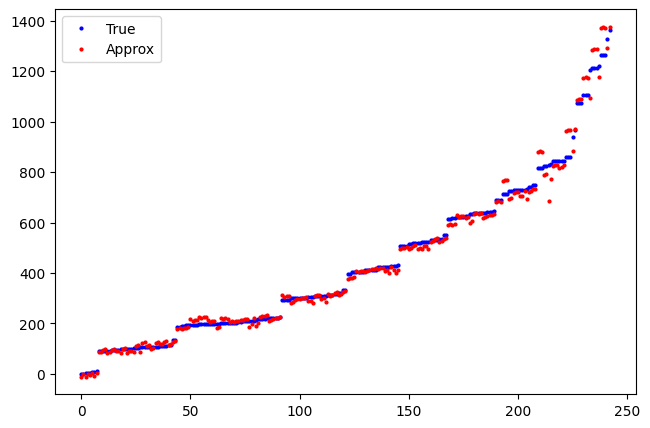

In [475]:
figure(figsize=((3/2)*5, 5))
gap = mean(trueValues - approxValues)
ptSize = 2
PyPlot.plot(trueValues , "bo", label = "True", ms = ptSize)
PyPlot.plot(approxValues.+ gap, "ro", label = "Approx", ms = ptSize)
legend()
PyPlot.savefig("vfaVsTrue.pdf", bbox_inches="tight")

In [347]:
gaps = trueValues - approxValues .- gap

243-element Vector{Float64}:
 -107.91452235625638
 -160.1638461793782
 -147.5386114938192
 -199.27772737635678
 -176.32527267371552
 -227.55930381080907
 -214.51606529204673
 -263.7499698549036
 -114.01780754407446
 -114.85389441289954
 -166.23899958084166
 -167.07508644966674
 -153.60382219609892
    ⋮
 -164.22171972924298
 -159.68105742185617
  -44.693636879538644
 -163.4345998019071
 -168.81134897811808
 -164.27068667073218
  -50.60275740594261
 -135.9210992438757
 -141.29784842008667
 -136.75718611270077
  -56.24260738178964
  -42.19548828237748

In [350]:
test = [stateSpace[i] for i in 1:243 if gaps[i] >= 100]
for t in test
    println(t)
end

[3, 3, 1, 1, 1]
[2, 2, 1, 1, 1]
[3, 2, 1, 1, 1]
[2, 3, 1, 1, 1]
[3, 3, 1, 1, 3]
[2, 2, 1, 1, 3]
[3, 2, 1, 1, 3]
[2, 3, 1, 1, 3]
[3, 3, 3, 1, 1]
[2, 2, 3, 1, 1]
[3, 2, 3, 1, 1]
[2, 3, 3, 1, 1]
[3, 3, 1, 3, 1]
[2, 2, 1, 3, 1]
[3, 2, 1, 3, 1]
[2, 3, 1, 3, 1]
[2, 2, 3, 1, 3]
[3, 2, 3, 1, 3]
[2, 3, 3, 1, 3]
[3, 3, 3, 1, 3]
[2, 2, 1, 3, 3]
[3, 2, 1, 3, 3]
[2, 3, 1, 3, 3]
[3, 3, 1, 3, 3]
[2, 2, 3, 3, 1]
[3, 2, 3, 3, 1]
[2, 3, 3, 3, 1]
[3, 3, 3, 3, 1]
[3, 3, 1, 1, 2]
[2, 2, 1, 1, 2]
[3, 2, 1, 1, 2]
[2, 3, 1, 1, 2]
[2, 2, 3, 1, 2]
[3, 2, 3, 1, 2]
[2, 3, 3, 1, 2]
[3, 3, 3, 1, 2]
[2, 2, 1, 3, 2]
[3, 2, 1, 3, 2]
[2, 3, 1, 3, 2]
[3, 3, 1, 3, 2]
[3, 3, 2, 1, 1]
[2, 2, 2, 1, 1]
[3, 2, 2, 1, 1]
[2, 3, 2, 1, 1]
[2, 2, 2, 1, 3]
[3, 2, 2, 1, 3]
[2, 3, 2, 1, 3]
[3, 3, 2, 1, 3]
[2, 2, 2, 3, 1]
[3, 2, 2, 3, 1]
[2, 3, 2, 3, 1]
[3, 3, 2, 3, 1]
[2, 2, 2, 1, 2]
[3, 2, 2, 1, 2]
[2, 3, 2, 1, 2]
[3, 3, 2, 1, 2]
[3, 3, 1, 2, 1]
[2, 2, 1, 2, 1]
[3, 2, 1, 2, 1]
[2, 3, 1, 2, 1]
[2, 2, 1, 2, 3]
[3, 2, 1, 2, 3]
[2, 3, 1

In [355]:
test2 = []
for t in test
    cand = t[3:5]
    unique = true
    for t2 in test2
        if cand == t2
            unique = false
            break
        end
    end

    if unique
        push!(test2, cand)
    end
end

In [356]:
test2

19-element Vector{Any}:
 [1, 1, 1]
 [1, 1, 3]
 [3, 1, 1]
 [1, 3, 1]
 [3, 1, 3]
 [1, 3, 3]
 [3, 3, 1]
 [1, 1, 2]
 [3, 1, 2]
 [1, 3, 2]
 [2, 1, 1]
 [2, 1, 3]
 [2, 3, 1]
 [2, 1, 2]
 [1, 2, 1]
 [1, 2, 3]
 [3, 2, 1]
 [1, 2, 2]
 [2, 2, 1]

In [357]:
options = enumerateStates(3)
options2 = []
for o in options
    found = false
    for t2 in test2
        if o == t2
            found = true
            break
        end
    end

    if !found
        push!(options2, o)
    end
end

In [359]:
options2

8-element Vector{Any}:
 [2, 2, 2]
 [3, 2, 2]
 [2, 3, 2]
 [3, 3, 2]
 [2, 2, 3]
 [3, 2, 3]
 [2, 3, 3]
 [3, 3, 3]

All poor estimates have DIP links either damaged or repairing, and at least 1 non-DIP link healthy

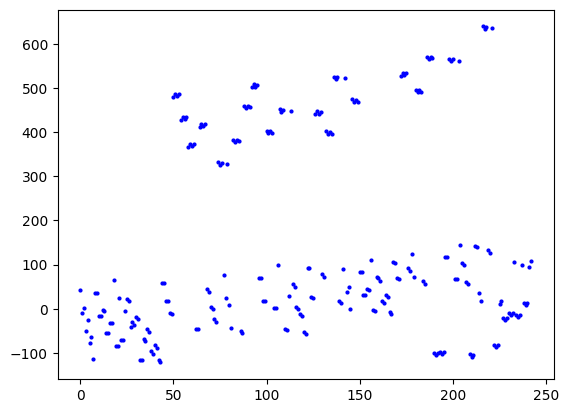

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f54e358fe50>

In [354]:
PyPlot.plot(gaps .+ 150, "bo", ms =2)

In [284]:
importantStates[7]

5-element Vector{Int64}:
 1
 3
 3
 3
 3

In [ ]:
median(optGapsApprox)